In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import pearsonr

In [3]:
import utils_plot
import utils_config
from utils_plot import plot_barplot, plot_boxplot

In [4]:
import met_brewer

## Settings

In [5]:
TEXT_WIDTH = 6.7261  # in
DPI = 360

In [6]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

# Settings

In [7]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(20)

# Load data
## Raw data

In [8]:
known_epitopes = [
    'QYIKWPWYI',
    'NYNYLYRLF',
    'LTDEMIAQY',
    'YLQPRTFLL',
    'GILGFVFTL', 
    'SPRRARSVA',
    'CTELKLSDY',
    'AYAQKIFKI',
    'RLQSLQTYV',
    'NLVPMVATV',
    'YVLDHLIVV',
    'FPQSAPHGV',   
    'KCYGVSPTK',
    'TYGPVFMCL'
]

In [9]:
df_data = pd.read_csv('../tcr_benchmark/data/viral.csv', index_col=0)
df_data['In VDJdb'] = df_data['Epitope'].apply(lambda x: 'True' if x in known_epitopes else 'False')
df_data.head()

,CDR3_alpha,CDR3_beta,V_alpha,V_beta,J_alpha,J_beta,Epitope,clone_id,MHC,In VDJdb
0,CAVNAPTGTASKLTF,CASSMRSAVEQYF,TRAV8-1*01,TRBV19*01,TRAJ44*01,TRBJ2-7*01,GILGFVFTL,25.0,HLA-A*02:01,True
1,CAVEGSQGNLIF,CASSMRSAVEQYF,TRAV2*01,TRBV19*01,TRAJ42*01,TRBJ2-7*01,GILGFVFTL,27.0,HLA-A*02:01,True
2,CAGWPGSSNTGKLIF,CASSIRSLAEQYF,TRAV25*01,TRBV19*01,TRAJ37*01,TRBJ2-7*01,GILGFVFTL,34.0,HLA-A*02:01,True
3,CAVRDAILTGGGNKLTF,CASRRQGITETQYF,TRAV3*01,TRBV27*01,TRAJ10*01,TRBJ2-5*01,GILGFVFTL,35.0,HLA-A*02:01,True
4,CATEDNDMRF,CASSFSDTQYF,TRAV17*01,TRBV5-4*01,TRAJ43*01,TRBJ2-3*01,YVLDHLIVV,39.0,HLA-A*02:01,True


In [10]:
df_data['MHC'].value_counts()

MHC
HLA-A*24:02    249
HLA-A*01:01    143
HLA-A*03:01    127
HLA-A*02:01     79
HLA-B*07:02     40
Name: count, dtype: int64

In [11]:
len(df_data)

638

In [12]:
epitopes = df_data['Epitope'].value_counts().index.tolist()
palette_epitopes = met_brewer.met_brew(name='Signac', n=14, brew_type='discrete')
palette_epitopes = dict(zip(epitopes, palette_epitopes))

In [97]:
amount_epis = df_data['Epitope'].value_counts()
amount_epis

Epitope
LTDEMIAQY    129
KCYGVSPTK    127
NYNYLYRLF    116
QYIKWPWYI    114
YLQPRTFLL     49
SPRRARSVA     31
CTELKLSDY     14
GILGFVFTL     13
TYGPVFMCL     10
AYAQKIFKI      9
FPQSAPHGV      9
YVLDHLIVV      6
RLQSLQTYV      6
NLVPMVATV      5
Name: count, dtype: int64

In [58]:
df_data['Epitope'].value_counts()[:4].sum()

486

In [14]:
df_data['Epitope'].value_counts(normalize=True)[:4].sum()

0.7617554858934168

### Databases

In [15]:
iedb = pd.read_csv('../data/processed/iedb.csv', index_col=0)
vdjdb = pd.read_csv('../data/processed/vdjdb.csv', index_col=0)
mcpas = pd.read_csv('../data/processed/mcpas_tcr.csv', index_col=0)
df_all_dbs = pd.concat([iedb, vdjdb, mcpas])[['CDR3_beta', 'Epitope']].drop_duplicates()
df_all_dbs = df_all_dbs[df_all_dbs['CDR3_beta'].notna()]
df_all_dbs = df_all_dbs[df_all_dbs['Epitope'].isin(df_data['Epitope'].unique())]
df_all_dbs = pd.DataFrame(df_all_dbs.groupby('Epitope')['CDR3_beta'].nunique())
df_all_dbs

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2482750333.py:1: DtypeWarning: Columns (1,2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  iedb = pd.read_csv('../data/processed/iedb.csv', index_col=0)


,CDR3_beta
Epitope,
AYAQKIFKI,41
CTELKLSDY,102
GILGFVFTL,7289
KCYGVSPTK,223
LTDEMIAQY,128
NLVPMVATV,6916
NYNYLYRLF,52
QYIKWPWYI,150
RLQSLQTYV,94


### Performance

In [16]:
path_viral = '../results/results_viral_all_models_and_options.csv'
df_performance_all = pd.read_csv(path_viral, index_col=0)
df_performance_all['Metric'] = df_performance_all['Metric'].replace('AverageRank', 'Rank')
df_performance_all['BaseModel'] = df_performance_all['Method'].str.split('_').str[0]
df_performance_all['Variant'] = df_performance_all['Method'].str.split('_').str[1:].str.join('_')
df_performance_all.head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,bertrand,Viral,full_data,638,MPS,Rank,6.923197,bertrand,
1,bertrand,Viral,full_data,638,MPS,R@1,0.072100,bertrand,
2,bertrand,Viral,full_data,638,MPS,R@3,0.429467,bertrand,
3,bertrand,Viral,full_data,638,MPS,R@5,0.468652,bertrand,
4,bertrand,Viral,full_data,638,MPS,R@8,0.515674,bertrand,


In [17]:
df_performance_all['Metric'].value_counts()

Metric
Rank         1020
R@1          1020
R@3          1020
R@5          1020
R@8          1020
AUC          1020
APS          1020
F1-Score     1020
Accuracy     1020
Precision    1020
Recall       1020
Name: count, dtype: int64

In [18]:
df_performance_all['Support'].value_counts()

Support
638     5340
14      1620
9        600
6        600
8932     360
5        300
114      300
13       300
10       300
127      300
49       300
129      300
31       300
116      300
Name: count, dtype: int64

In [19]:
df_performance_all['Group'].value_counts()

Group
full_data                660
Average                  660
WeightedAverage          660
YLQPRTFLL                360
GILGFVFTL                360
CTELKLSDY                360
NYNYLYRLF                360
FPQSAPHGV                360
KCYGVSPTK                360
NLVPMVATV                360
TYGPVFMCL                360
SPRRARSVA                360
RLQSLQTYV                360
QYIKWPWYI                360
LTDEMIAQY                360
YVLDHLIVV                360
AYAQKIFKI                360
GILGFVFTL_HLA-A*02:01    300
NLVPMVATV_HLA-A*02:01    300
NYNYLYRLF_HLA-A*24:02    300
CTELKLSDY_HLA-A*01:01    300
YVLDHLIVV_HLA-A*02:01    300
SPRRARSVA_HLA-B*07:02    300
LTDEMIAQY_HLA-A*01:01    300
YLQPRTFLL_HLA-A*02:01    300
RLQSLQTYV_HLA-A*02:01    300
KCYGVSPTK_HLA-A*03:01    300
TYGPVFMCL_HLA-A*24:02    300
AYAQKIFKI_HLA-A*24:02    300
QYIKWPWYI_HLA-A*24:02    300
FPQSAPHGV_HLA-B*07:02    300
Name: count, dtype: int64

## Select best model Version
If a method provided several models, we will select the one with the best AUC macro-averaged over all epitopes.

In [20]:
best_models = df_performance_all[(df_performance_all['Metric']=='AUC')
                                 & (~df_performance_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                                ].groupby('Method')['Value'].mean()
best_models = pd.DataFrame(best_models.sort_values(ascending=False)).reset_index()
best_models['Name'] = best_models['Method'].str.split('_').str[0]
best_models = best_models.drop_duplicates('Name', keep='first')['Method'].tolist()
best_models

['tulip-tcr',
 'nettcr_t.1.v.0',
 'teinet_SMALL_DS',
 'stapler',
 'ergo-ii_VDJDB',
 'titan',
 'ergo-i_AE_VDJDB',
 'atm-tcr',
 'imrex_FULL',
 'teim',
 'itcep',
 'bertrand',
 'dlptcr_BETA',
 'pmtnet',
 'tcellmatch_LINEAR_CV1',
 'epitcr_WITH_MHC',
 'attntap_VDJDB',
 'panpep']

In [21]:
df_performance_all[(df_performance_all['BaseModel']=='teinet')
                  & (df_performance_all['Metric']=='AUC')
                  & (~df_performance_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                  ].groupby('Variant')['Value'].mean()

Variant
LARGE_DS    0.593086
SMALL_DS    0.611226
Name: Value, dtype: float64

In [22]:
df_performance_best = df_performance_all[df_performance_all['Method'].isin(best_models)].copy()
df_performance_best.head()

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,bertrand,Viral,full_data,638,MPS,Rank,6.923197,bertrand,
1,bertrand,Viral,full_data,638,MPS,R@1,0.072100,bertrand,
2,bertrand,Viral,full_data,638,MPS,R@3,0.429467,bertrand,
3,bertrand,Viral,full_data,638,MPS,R@5,0.468652,bertrand,
4,bertrand,Viral,full_data,638,MPS,R@8,0.515674,bertrand,


## Performance Alternative Models

In [23]:
mapper_alt_names = {
    'LSTM_CV0': 'LSTM 0', 
    'LSTM_CV1': 'LSTM 1', 
    'LSTM_CV2': 'LSTM 2', 
    'GRU_CV0': 'GRU 0', 
    'GRU_CV1': 'GRU 1',
    'GRU_CV2': 'GRU 2', 
    'GRU_SEP_CV0': 'GRU-sep 0', 
    'GRU_SEP_CV1': 'GRU-sep 1', 
    'GRU_SEP_CV2': 'GRU-sep 2',
    'LSTM_SEP_CV0': 'LSTM-sep 0', 
    'LSTM_SEP_CV1': 'LSTM-sep 1', 
    'LSTM_SEP_CV2': 'LSTM-sep 2', 
    'LINEAR_CV0': 'Linear 0',
    'LINEAR_CV1': 'Linear 1', 
    'LINEAR_CV2': 'Linear 2', 
    'AE_VDJDB': 'AE VDJdb', 
    'LSTM_VDJDB': 'LSTM VDJdb', 
    'AE_MCPAS': 'AE McPas',
    'LSTM_MCPAS': 'LSTM McPas', 
    'VDJDB': 'VDJdb', 
    'MCPAS': 'McPas', 
    'DOWNSAMPLED': 'Small DS', 
    'FULL': 'Large DS', 
    'LARGE_DS': 'Large DS',
    'SMALL_DS': 'Small DS', 
    'WITH_MHC': 'with MHC', 
    'WO_MHC': 'wo MHC', 
    'ALPHA_BETA': 'Both chains', 
    'ALPHA': 'Alpha', 
    'BETA': 'Beta',
    't.0.v.1': 'T0.V1', 
    't.0.v.2': 'T0.V2', 
    't.0.v.3': 'T0.V3',
    't.0.v.4': 'T0.V4', 
    't.1.v.0': 'T1.V1', 
    't.1.v.2': 'T1.V2',
    't.1.v.3': 'T1.V3', 
    't.1.v.4': 'T1.V4', 
    't.2.v.0': 'T2.V1',
    't.2.v.1': 'T2.V2', 
    't.2.v.3': 'T2.V3', 
    't.2.v.4': 'T2.V4',
    't.3.v.0': 'T3.V0', 
    't.3.v.1': 'T3.V1', 
    't.3.v.2': 'T3.V2',
    't.3.v.4': 'T3.V4', 
    't.4.v.0': 'T4.V0', 
    't.4.v.1': 'T4.V1',
    't.4.v.2': 'T4.V2', 
    't.4.v.3': 'T4.V3'
}

In [24]:
df_performance_alt = df_performance_all[df_performance_all['Variant']!=''].copy()
df_performance_alt['Metric'] = df_performance_alt['Metric'].replace('AverageRank', 'Rank')
df_performance_alt['Variant'] = df_performance_alt['Variant'].map(mapper_alt_names)
df_performance_alt['Method'] = df_performance_alt['BaseModel'] + ' ' + df_performance_alt['Variant']
df_performance_alt.head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,tcellmatch LSTM 0,Viral,full_data,638,MPS,Rank,7.758621,tcellmatch,LSTM 0
1,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@1,0.083072,tcellmatch,LSTM 0
2,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@3,0.210031,tcellmatch,LSTM 0
3,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@5,0.299373,tcellmatch,LSTM 0
4,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@8,0.567398,tcellmatch,LSTM 0


## Prediction Score

In [25]:
model_names_score = sorted(df_performance_best['Method'].unique())

prediction_scores = pd.read_csv(f'../tcr_benchmark/results/predictions_{model_names_score[0]}_viral.csv', index_col=0)
prediction_scores = prediction_scores.drop(columns=['Score'])
for tag in model_names_score:
    df_tmp = pd.read_csv(f'../tcr_benchmark/results/predictions_{tag}_viral.csv', index_col=0)
    prediction_scores[tag] = df_tmp['Score'].values
prediction_scores.head()

,CDR3_alpha,CDR3_beta,V_alpha,V_beta,J_alpha,J_beta,Epitope,clone_id,MHC,Label,...,itcep,nettcr_t.1.v.0,panpep,pmtnet,stapler,tcellmatch_LINEAR_CV1,teim,teinet_SMALL_DS,titan,tulip-tcr
0,CAVNAPTGTASKLTF,CASSMRSAVEQYF,TRAV8-1*01,TRBV19*01,TRAJ44*01,TRBJ2-7*01,GILGFVFTL,25.0,HLA-A*02:01,1,...,0.9990,0.992697,0.675948,0.9510,0.999178,0.894294,0.979334,0.999998,0.991495,-0.003135
1,CAVEGSQGNLIF,CASSMRSAVEQYF,TRAV2*01,TRBV19*01,TRAJ42*01,TRBJ2-7*01,GILGFVFTL,27.0,HLA-A*02:01,1,...,0.9990,0.975952,0.675948,0.9510,0.999480,0.894294,0.979334,0.999998,0.991495,-0.001602
2,CAGWPGSSNTGKLIF,CASSIRSLAEQYF,TRAV25*01,TRBV19*01,TRAJ37*01,TRBJ2-7*01,GILGFVFTL,34.0,HLA-A*02:01,1,...,0.9995,0.982557,0.435693,0.9710,0.998268,0.907589,0.986296,1.000000,0.992025,-0.001996
3,CAVRDAILTGGGNKLTF,CASRRQGITETQYF,TRAV3*01,TRBV27*01,TRAJ10*01,TRBJ2-5*01,GILGFVFTL,35.0,HLA-A*02:01,1,...,0.9914,0.095337,0.395284,0.0640,0.010665,0.864357,0.040731,0.115249,0.948033,-2.086307
4,CATEDNDMRF,CASSFSDTQYF,TRAV17*01,TRBV5-4*01,TRAJ43*01,TRBJ2-3*01,GILGFVFTL,39.0,HLA-A*02:01,0,...,0.9906,0.008768,0.812457,0.9914,0.029653,0.814019,0.767383,0.281288,0.877806,-1.959406


In [26]:
prediction_scores.to_csv('../supplement/S2_prediction_scores_viral_dataset.csv')

## Load Predictor Properties

In [27]:
df_properties = pd.read_csv('../data/predictor_properties.csv')
df_properties['Date'] = df_properties['Date_str'].str.split('/').str[1].astype(float)
df_properties['Date'] += df_properties['Date_str'].str.split('/').str[0].astype(float)/12
df_properties

,Method,Date_str,Date
0,ATM-TCR,07/2022,2022.583333
1,AttnTAP,08/2022,2022.666667
2,BERTrand,01/2023,2023.083333
3,DLpTCR,11/2021,2021.916667
4,epiTCR,04/2023,2023.333333
5,ERGO,05/2019,2019.416667
6,ERGO-II,04/2021,2021.333333
7,ImRex,12/2020,2021.000000
8,iTCep,01/2023,2023.083333
9,NetTCR-2.2,1/2023,2023.083333


# Plotting functions

In [28]:
from matplotlib.patches import Patch
color_known = '#798897'
color_unknown = 'salmon'

In [29]:
epitope_2_mhc = df_data[['Epitope', 'MHC']].drop_duplicates()
epitope_2_mhc = dict(zip(epitope_2_mhc['Epitope'], epitope_2_mhc['MHC'])) 

In [30]:
mhc_colors = met_brewer.met_brew(name="Isfahan2", n=5, brew_type="discrete")  # sb.color_palette('deep')
mhc_colors = {
    'HLA-A*02:01': mhc_colors[0],  #mhc_colors[0], 
    'HLA-A*24:02': mhc_colors[1],  #mhc_colors[1], 
    'HLA-A*03:01': mhc_colors[2],  #mhc_colors[2], 
    'HLA-A*01:01': mhc_colors[3],  #mhc_colors[5],
    'HLA-B*07:02': mhc_colors[4],  #mhc_colors[4]
}
epitope_mhc_colors = {e: mhc_colors[m] for e, m in epitope_2_mhc.items()}

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1031268501.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=colors,


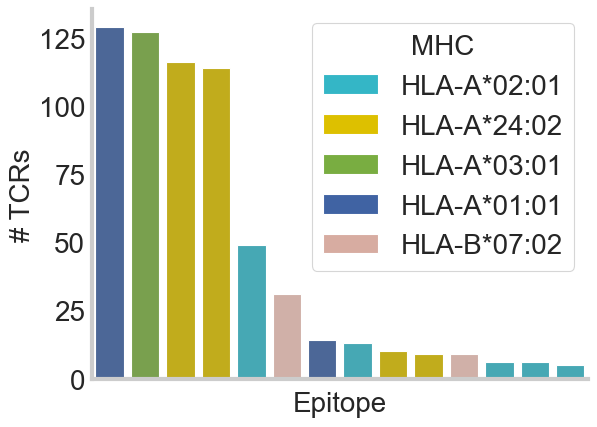

In [31]:
def plot_epitopes(ax=None):
    df_tmp = pd.DataFrame(df_data['Epitope'].value_counts())
    df_tmp['In VDJdb'] = df_tmp.index.map(lambda x: color_known if x in known_epitopes else color_unknown)
    df_tmp = df_tmp.rename(columns={'count': '# TCRs'})
    df_tmp['Epitope'] = df_tmp.index
    colors = [epitope_mhc_colors[e] for e in df_tmp['Epitope']]
    
    plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=colors,
                     ax=ax)    
    plot.set_xticklabels([])
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    
    custom_legend = [Patch(facecolor=c, label=l) for l, c in mhc_colors.items()]
    plot.legend(handles=custom_legend, title='MHC')
    plot.tick_params(axis='both', pad=0)
    plot.set_ylabel('# TCRs', labelpad=2)

plot_epitopes()

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2524682350.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.boxplot(data=df_tmp, x='Group', y='Value', ax=ax, order=order,
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2524682350.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


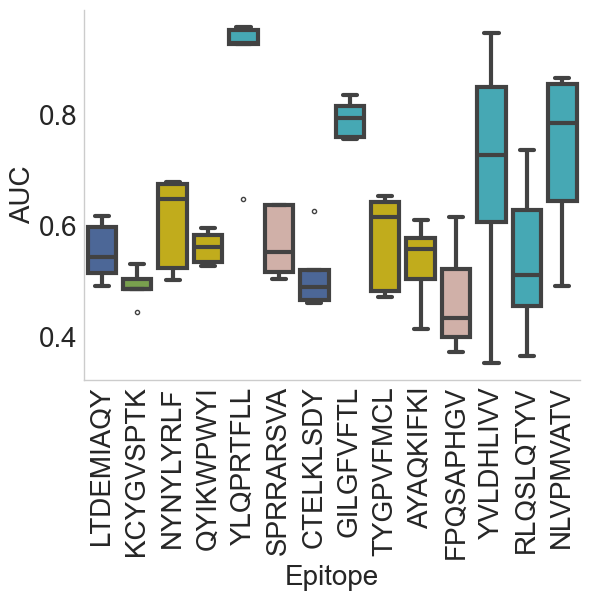

In [32]:
def plot_metric_by_epitope(df, metric, n_top=None, ax=None):
    df_tmp = df[df['Metric']==metric]
    if n_top:
        best_models = df_tmp[df_tmp['Group']=='WeightedAverage'].sort_values('Value')['BaseModel'][-n_top:].values
        df_tmp = df_tmp[df_tmp['BaseModel'].isin(best_models)]
    
    df_tmp = df_tmp[~df_tmp['Group'].isin(['Average', 'WeightedAverage', 'full_data'])]
    
    order = df_data['Epitope'].value_counts().index.tolist()
    plot = sb.boxplot(data=df_tmp, x='Group', y='Value', ax=ax, order=order,
                      palette=epitope_mhc_colors,
                      capprops = {"linewidth": utils_plot.LINEWIDTH},
                      flierprops={'markersize': 3},
                      medianprops = {'linewidth': utils_plot.LINEWIDTH},
                      boxprops={"linewidth": utils_plot.LINEWIDTH},
                      whiskerprops = {"linewidth": utils_plot.LINEWIDTH},)
    
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.tick_params(axis='both', pad=0)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel('Epitope')

plot_metric_by_epitope(df_performance_best, 'AUC', 5)

0.04886701242973779


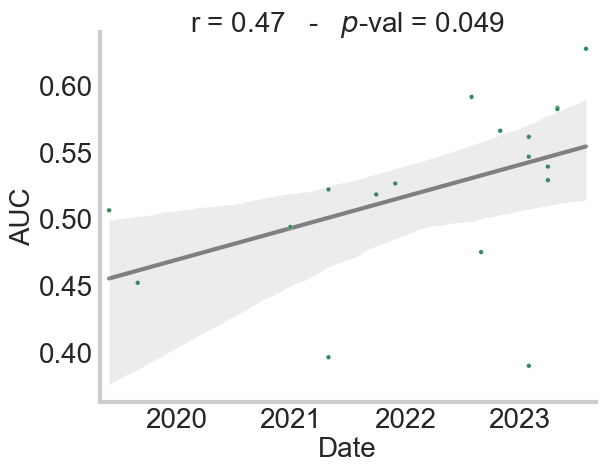

In [33]:
def plot_property_vs_performance(prop, metric, ax=None):
    df_scores = df_performance_best[df_performance_best['Metric']==metric]
    df_scores = df_scores[df_scores['Group']=='full_data'].set_index('BaseModel')[['Value']]
    df_scores.index = df_scores.index.map(utils_config.mapper_methods)
    
    df_props = df_properties.set_index('Method')[[prop]]
    df_combined = pd.concat([df_scores, df_props], axis=1).fillna(0)
    
    plot = sb.scatterplot(data=df_combined, x=prop, y='Value',
                         size=1, color='seagreen', ax=ax)
    plot = sb.regplot(data=df_combined, 
                      x=prop, y='Value',
                      color='gray', ax=ax, 
                      scatter=False, line_kws={'zorder': -1, 'linewidth': utils_plot.LINEWIDTH})
    
    delta = df_combined[prop].max() - df_combined[prop].min()
    plot.set_xlim(df_combined[prop].min()-0.02*delta, df_combined[prop].max()+0.02*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    plot.tick_params(axis='both', pad=0)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel(prop, labelpad=2)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_combined[prop].values, df_combined['Value'].values)
    print(p_val)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_property_vs_performance('Date', 'AUC')

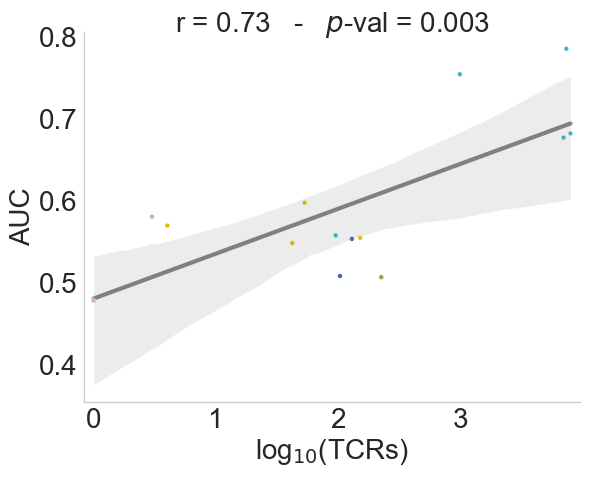

In [34]:
def plot_dbs_vs_performance(df, metric, n_top=5, ax=None):
    df_tmp = df[df['Metric']==metric]
    if n_top:
        best_models = df_tmp[df_tmp['Group']=='WeightedAverage'].sort_values('Value')['BaseModel'][-n_top:].values
        df_tmp = df_tmp[df_tmp['BaseModel'].isin(best_models)]
    
    df_tmp = df_tmp[~df_tmp['Group'].isin(['Average', 'WeightedAverage', 'full_data'])]
    df_tmp = df_tmp.groupby('Group')['Value'].mean()
    df_tmp = pd.DataFrame(df_tmp)
    df_tmp = pd.concat([df_tmp, df_all_dbs], axis=1).fillna(0)
    df_tmp['log(TCRs)'] = np.log10(1+df_tmp['CDR3_beta'])
    df_tmp['Epitope'] = df_tmp.index
    
    plot = sb.scatterplot(data=df_tmp, x='log(TCRs)', y='Value',
                          hue='Epitope', palette=epitope_mhc_colors,
                         size=1, color='seagreen', ax=ax)
    df_tmp = df_tmp.copy()
    plot = sb.regplot(data=df_tmp, x='log(TCRs)', y='Value',
                      color='gray', ax=ax, scatter=False, line_kws={'zorder': -1, 
                                                                    'linewidth': utils_plot.LINEWIDTH})
    delta = df_tmp['log(TCRs)'].max() - df_tmp['log(TCRs)'].min()
    plot.set_xlim(df_tmp['log(TCRs)'].min()-0.02*delta, df_tmp['log(TCRs)'].max()+0.02*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel('log$_{10}$(TCRs)', labelpad=2)
    plot.tick_params(axis='both', pad=0)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_tmp['log(TCRs)'].values, df_tmp['Value'].values)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_dbs_vs_performance(df_performance_best, 'AUC', 8)

## Figure Viral

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1031268501.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=colors,
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xti

0.04886701242973779


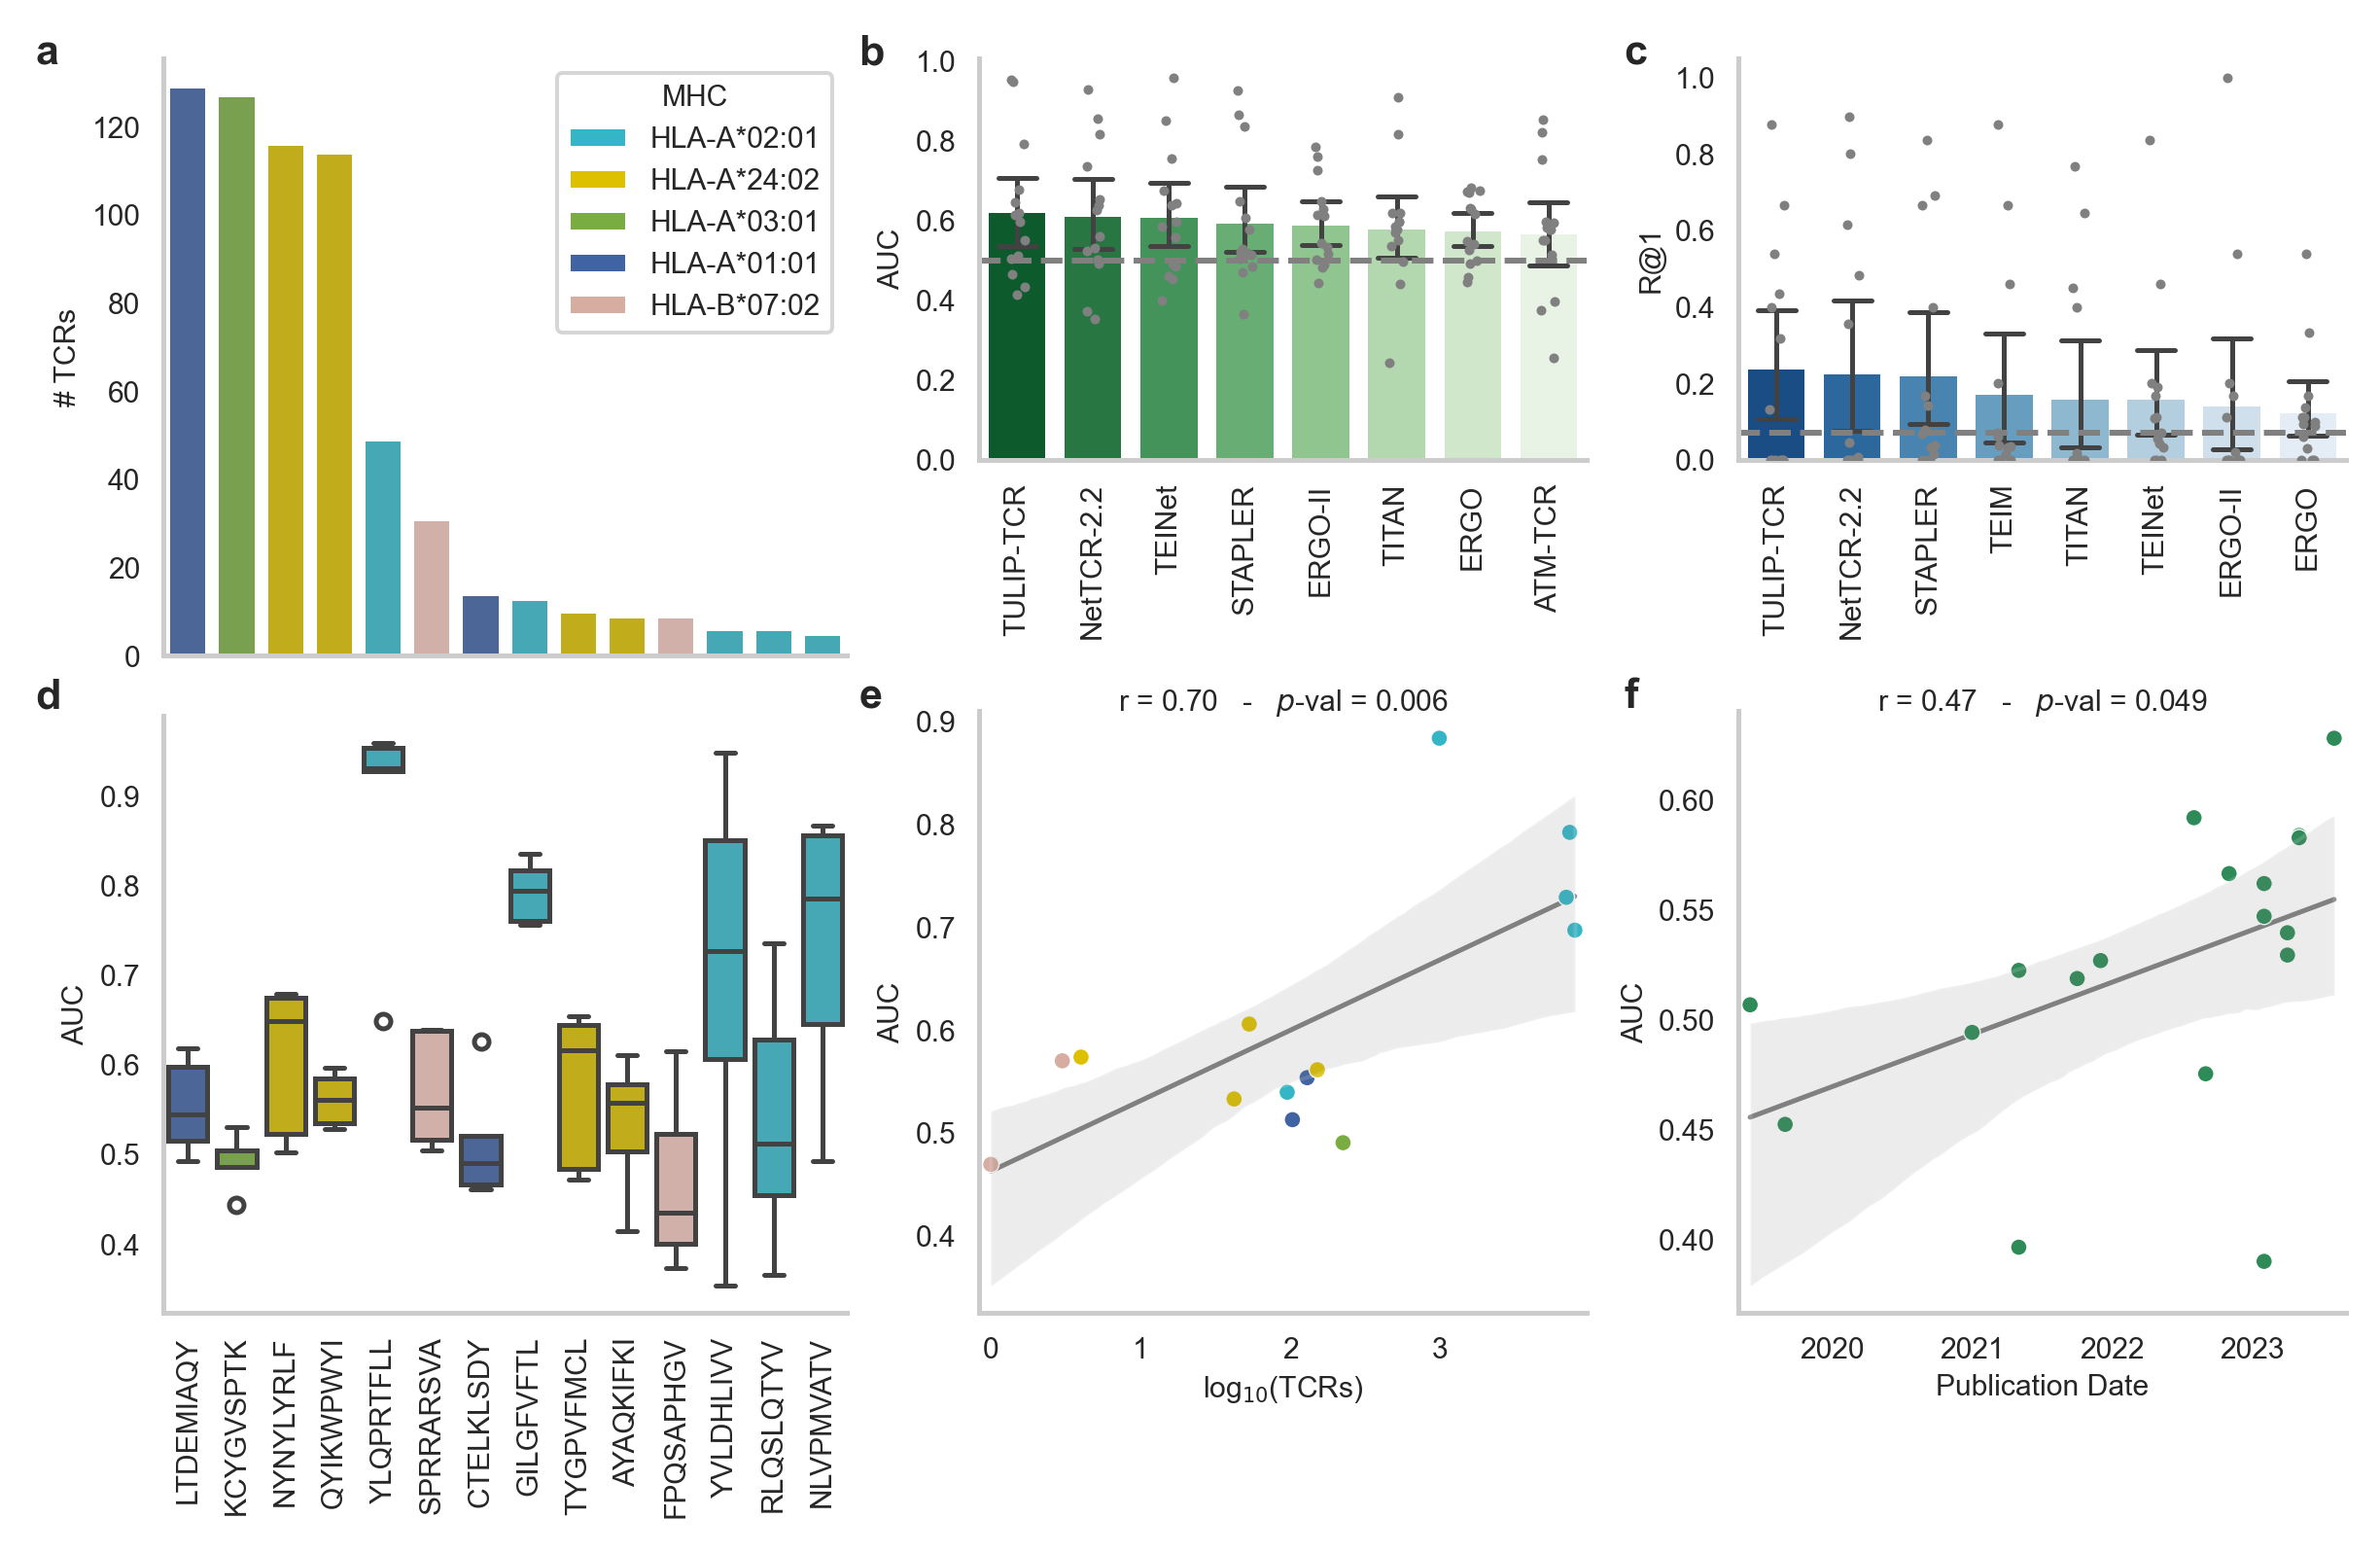

In [35]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.65),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1,],
    width_ratios=[1, 2],
)

gridspecs["ad"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.],
    width_ratios=[1, ],
    hspace=0.1
)

gridspecs["bcef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.5],
    width_ratios=[1, ],
    hspace=0.5
)


gridspecs["bc"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['bcef'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.25
)
gridspecs["ef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['bcef'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.25
)


ax_a = fig.add_subplot(gridspecs["ad"][0])
ax_b = fig.add_subplot(gridspecs["bc"][0])
ax_c = fig.add_subplot(gridspecs["bc"][1])

ax_d = fig.add_subplot(gridspecs["ad"][1])
ax_e = fig.add_subplot(gridspecs["ef"][0])
ax_f = fig.add_subplot(gridspecs["ef"][1])


plot_epitopes(ax_a)
ax_a.set_xlabel(None)
plot_barplot(df_performance_best, 'AUC', n_top=8, cmap='Greens_r', ax=ax_b, rdm=0.5)
plot_barplot(df_performance_best, 'R@1', n_top=8, cmap='Blues_r', ax=ax_c, rdm=1/14)

plot_metric_by_epitope(df_performance_best, 'AUC', 5, ax=ax_d)
ax_d.set_xlabel(None)
plot_dbs_vs_performance(df_performance_best, 'AUC', 5, ax=ax_e)
plot_property_vs_performance('Date', 'AUC', ax=None)
ax_f.set_xlabel('Publication Date')


fig.text(0.005, 0.97, 'a', size='x-large', weight='bold')
fig.text(0.355, 0.97, 'b', size='x-large', weight='bold')
fig.text(0.68, 0.97, 'c', size='x-large', weight='bold')

fig.text(0.005, 0.55, 'd', size='x-large', weight='bold')
fig.text(0.355, 0.55, 'e', size='x-large', weight='bold')
fig.text(0.68, 0.55, 'f', size='x-large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/fig_viral_benchmark.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/fig_viral_benchmark.png',
           dpi=DPI, bbox_inches='tight')

## SFigure 1 - All Models

D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90)
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Proje

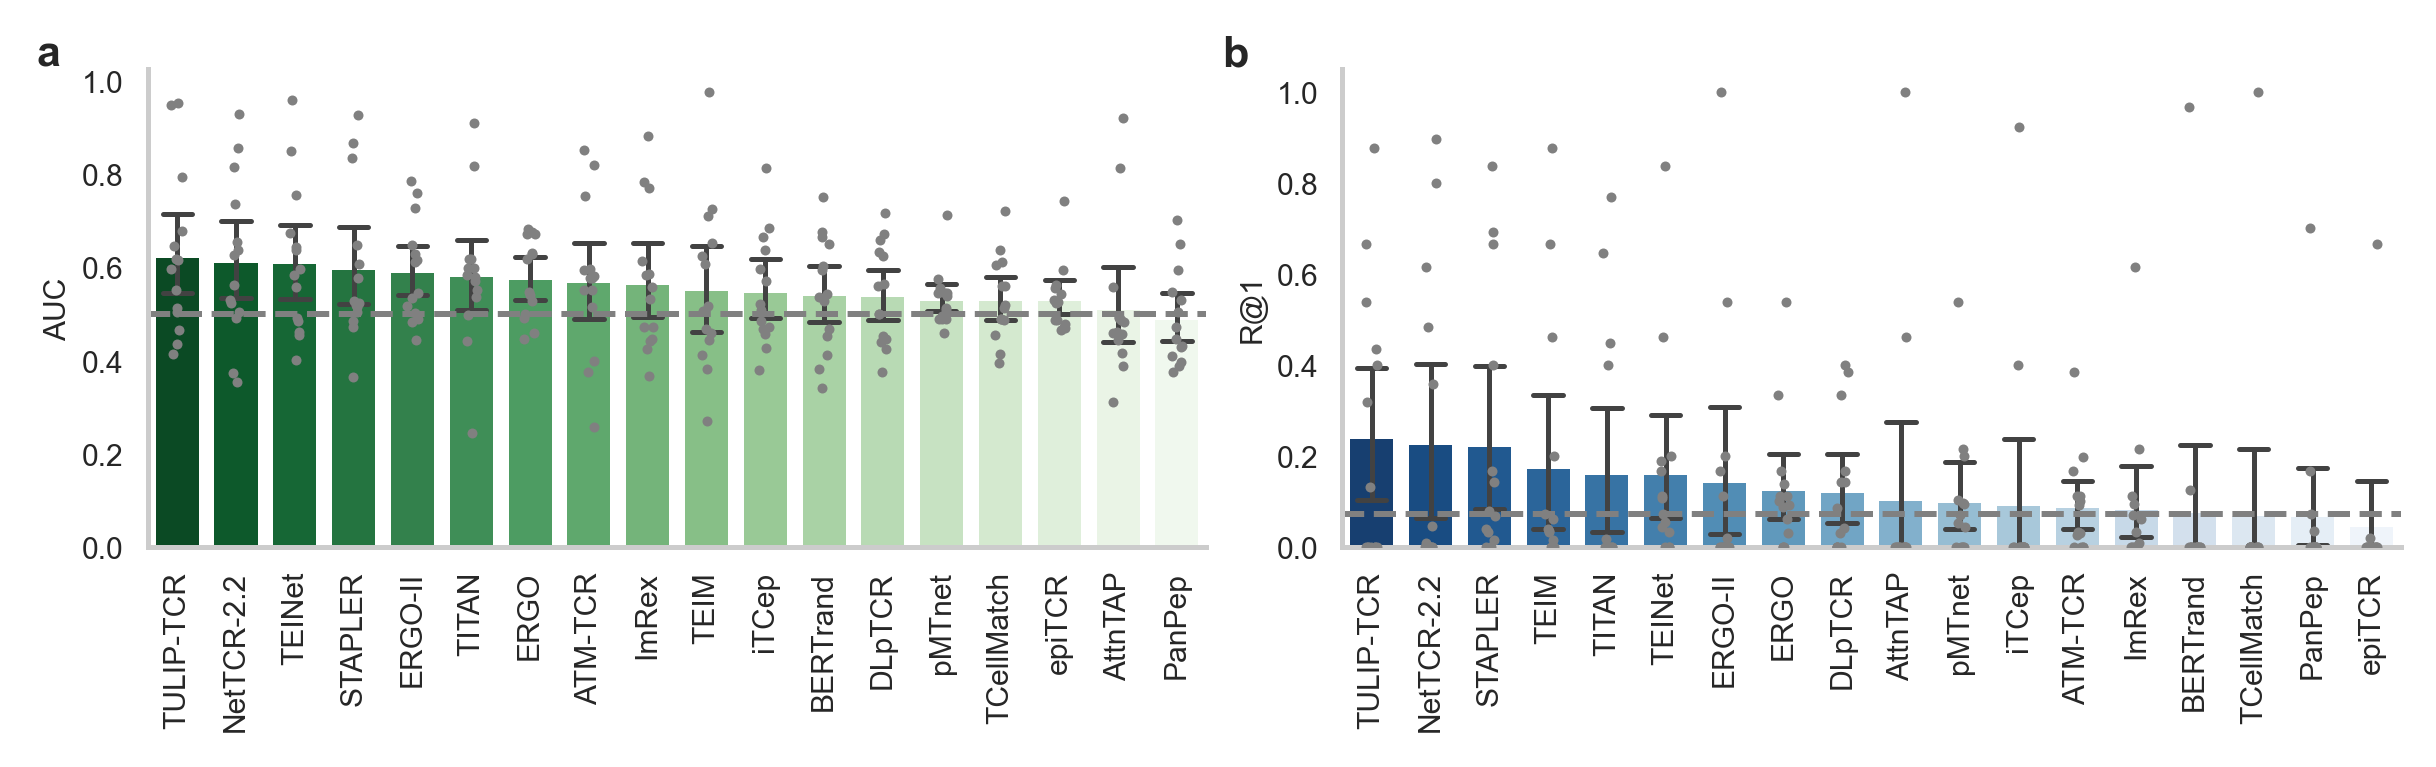

In [36]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.3),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1,],
    width_ratios=[1, 1],
)

ax_a = fig.add_subplot(gridspecs["full"][0])
ax_b = fig.add_subplot(gridspecs["full"][1])

plot_barplot(df_performance_best, 'AUC', n_top=18, cmap='Greens_r', ax=ax_a, rdm=0.5)
plot_barplot(df_performance_best, 'R@1', n_top=18, cmap='Blues_r', ax=ax_b, rdm=1/14)

fig.text(0.01, 0.96, 'a', size='x-large', weight='bold')
fig.text(0.5, 0.96, 'b', size='x-large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_all.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_all.png',
           dpi=DPI, bbox_inches='tight')

## SFigure 2 - Model Alternatives

In [37]:
base_methods = sorted(df_performance_alt['BaseModel'].unique(), key=lambda x: x.lower())
colors_models = {m: met_brewer.met_brew(name='Signac', n=9, brew_type='discrete')[i]  # sb.color_palette('pastel')[i] 
                 for i, m in enumerate(base_methods)}

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2758340092.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2758340092.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2758340092.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90)


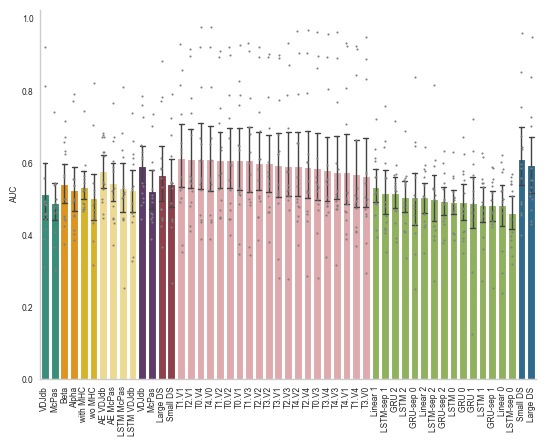

In [38]:
def plot_alternatives(df, metric, sort_by='Average', ax=None, rdm=None):
    df_plot = df[(df['Metric']==metric) & (~df['Group'].isin(['full_data', 'Average', 'WeightedAverage']))].copy()
    mean_perf = df_plot.groupby('Method')['Value'].mean().to_dict()
    df_plot['avgValue'] = df_plot['Method'].map(mean_perf)
    
    order = df[(df['Metric']=='AUC') & (df['Group']==sort_by)].sort_values(['BaseModel', 'Value'], ascending=[True, False],
                                                                           )['Method'].values
    
    order_base = df[(df['Metric']=='AUC') & (df['Group']==sort_by)].sort_values(['Method'])['BaseModel'].values
    palette = [colors_models[m] for m in order_base]

    plot = sb.barplot(data=df_plot, y='Value', x='Method',
                          order=order,
                          palette=palette,
                          errwidth=utils_plot.LINEWIDTH,
                          capsize=0.5,
                          ax=ax)
    plot = sb.stripplot(data=df_plot, y='Value', x='Method',
                          order=order,
                          color='gray',
                          size=1.5,
                          ax=ax)

    xlabels = plot.get_xticklabels()
    xlabels = [' '.join(el.get_text().split(' ')[1:]) for el in xlabels]
    plot.set_xticklabels(xlabels, rotation=90)

    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=0)

    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)

    if rdm is not None:
        plot.axhline(y=rdm, color='gray', linestyle='--')

plot_alternatives(df_performance_alt, 'AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2758340092.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2758340092.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2758340092.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\2758340092.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fa

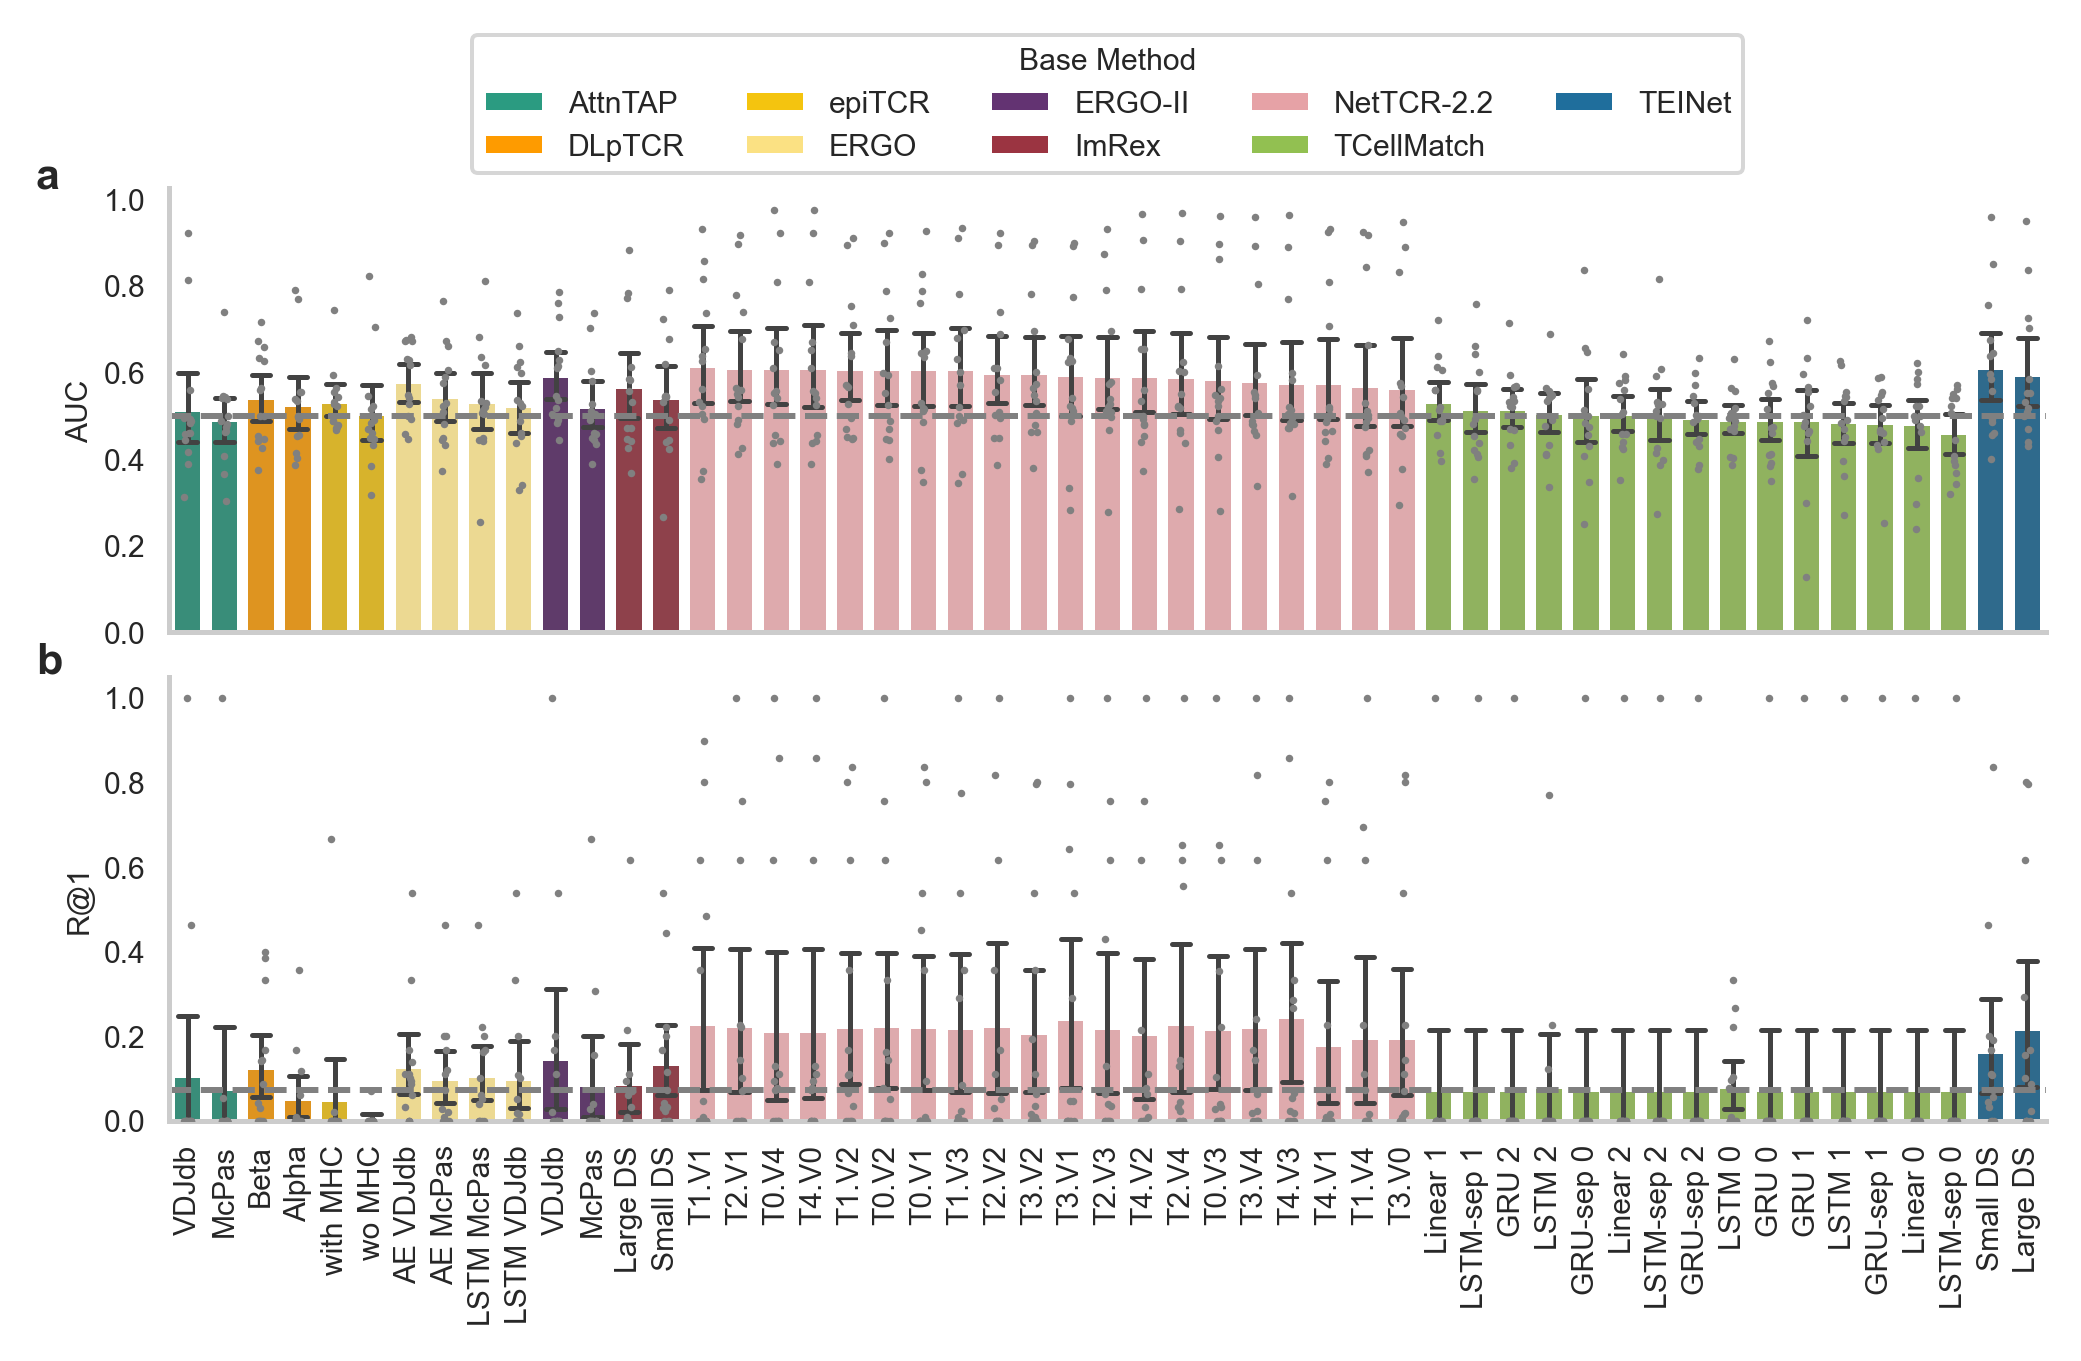

In [39]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.5),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
    hspace=0.1
)


for i, metric in enumerate(['AUC', 'R@1']):    
    ax_ = fig.add_subplot(gridspecs["full"][i])
    plot_alternatives(df_performance_alt, metric, sort_by='Average', ax=ax_, rdm=0.5 if i==0 else 1/14)
    
    if i == 0:
        ax_.set_xticklabels([])
        custom_legend = [Patch(facecolor=c, label=utils_config.mapper_methods[l]) for l, c in colors_models.items()]
        ax_.legend(handles=custom_legend, title='Base Method', ncol=5, bbox_to_anchor=(0.5, 1), loc='lower center')

fig.text(0.07, 0.88, 'a', size='x-large', weight='bold')
fig.text(0.07, 0.48, 'b', size='x-large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/sfig_viral_alternatives.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_alternatives.png',
           dpi=DPI, bbox_inches='tight')

## SFigure X - Positive vs Negative Scores

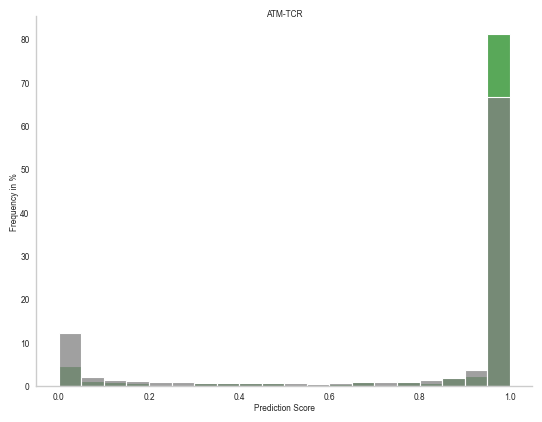

In [40]:
def plot_distribution(name, ax=None):
    n_bins = 20
    plot = sb.histplot(prediction_scores[prediction_scores['Label']==1], x=name, 
                      fill=True, color='forestgreen', label='Binding', stat='percent',
                      bins=n_bins,
                      common_norm=True, ax=ax)
    plot = sb.histplot(prediction_scores[prediction_scores['Label']==0], x=name, 
                      fill=True, color='gray', label='Non-binding', stat='percent',
                       bins=n_bins,
                      common_norm=True, ax=plot)
    
    plot.set_ylabel('Frequency in %', labelpad=1)
    plot.set_xlabel('Prediction Score', labelpad=1)
    plot.set_title(utils_config.mapper_methods[name.split('_')[0]], pad=0)
    plot.tick_params(axis='both', pad=0)
    
    sb.despine(ax=plot)
    plot.grid(False)
    
plot_distribution('atm-tcr')

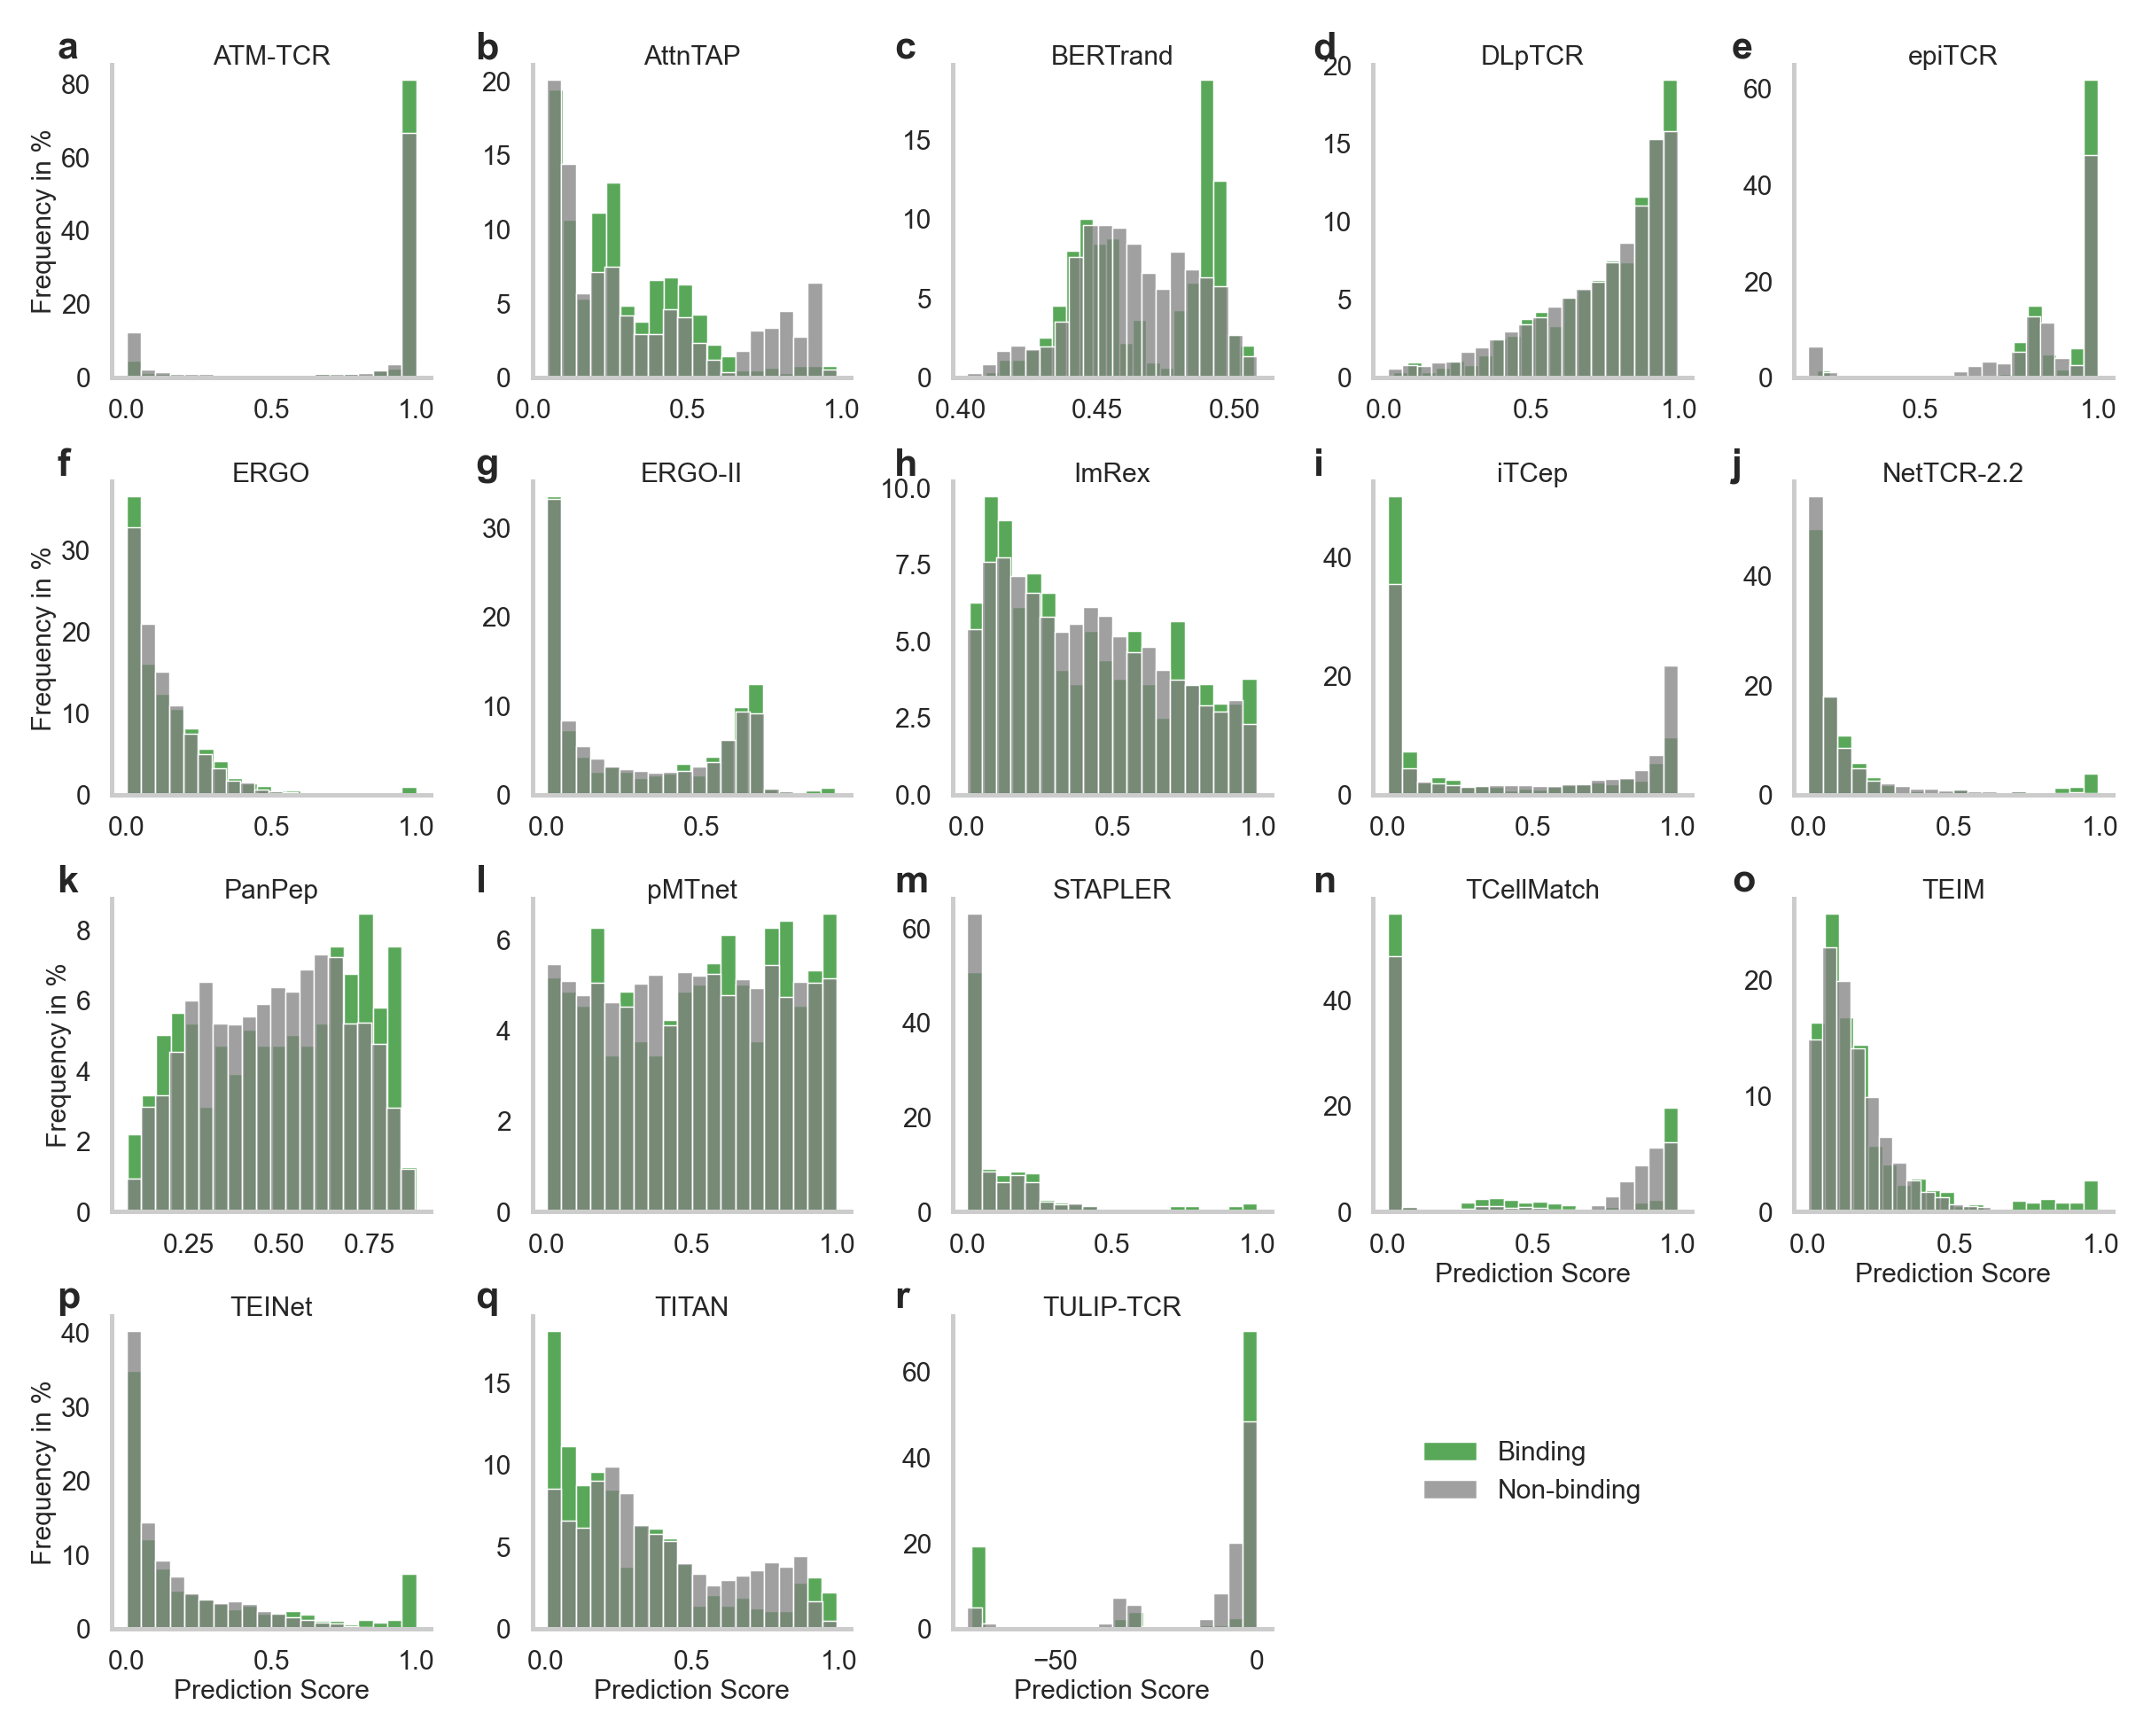

In [41]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.8),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=4,
    ncols=5,
    height_ratios=[1, 1, 1, 1],
    width_ratios=[1, 1, 1, 1, 1],
)


letters = 'abcdefghijklmnopqrstuvwxyz'
for i, tag in enumerate(model_names_score):
    ax_tmp = fig.add_subplot(gridspecs["full"][i])
    plot_distribution(tag, ax_tmp)
    
    if i%5 != 0:
        ax_tmp.set_ylabel(None)
    if i < 13:
        ax_tmp.set_xlabel(None)
    
    fig.text(1/5.125*(i%5)+0.025, 0.975-i//5*0.2425, letters[i], size='x-large', weight='bold')
    

handles, labels = ax_tmp.get_legend_handles_labels()
ax_tmp = fig.add_subplot(gridspecs["full"][i+1])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, 0.5), frameon=False)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_distributions.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_distributions.png',
           dpi=DPI, bbox_inches='tight')

## SFigure X - Rank Distribution => Majority Class?

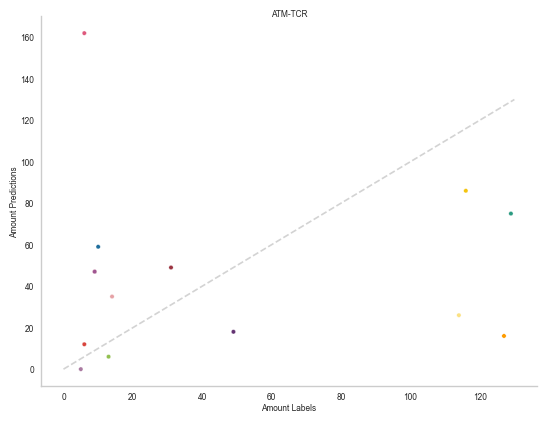

In [42]:
def plot_prediction_class(name, ax=None):
    df_counts = prediction_scores.sort_values(['clone_id', name], ascending=False)
    df_counts = df_counts.drop_duplicates(['clone_id', 'CDR3_alpha', 'CDR3_beta'], keep='first')['Epitope'].value_counts()
    df_counts = pd.DataFrame(df_counts)
    df_counts.columns = ['Amount Predictions']

    df_epis = pd.DataFrame(prediction_scores[prediction_scores['Label']==1]['Epitope'].value_counts())
    df_epis.columns = ['Amount Labels']
    df_counts = pd.concat([df_counts, df_epis], axis=1).fillna(0.0)
    df_counts['Epitope'] = df_counts.index
    df_counts = df_counts.sort_values('Amount Labels')
    
    plot = sb.scatterplot(data=df_counts, x='Amount Labels', y='Amount Predictions', hue='Epitope', 
                          palette=palette_epitopes, ax=ax, s=10)
    plot.plot([0, df_counts['Amount Labels'].max()+1], [0, df_counts['Amount Labels'].max()+1], 
              color='lightgrey', ls='--', zorder=-1)
    
    plot.set_ylabel('Amount Predictions', labelpad=1)
    plot.set_xlabel('Amount Labels', labelpad=1)
    plot.set_title(utils_config.mapper_methods[name.split('_')[0]], pad=0)
    plot.tick_params(axis='both', pad=0)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.legend().remove()
    
plot_prediction_class('atm-tcr', None)

scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.8),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=4,
    ncols=5,
    height_ratios=[1, 1, 1, 1],
    width_ratios=[1, 1, 1, 1, 1],
)


letters = 'abcdefghijklmnopqrstuvwxyz'
for i, tag in enumerate(model_names_score):
    ax_tmp = fig.add_subplot(gridspecs["full"][i])
    plot_prediction_class(tag, ax_tmp)
    
    if i%5 != 0:
        ax_tmp.set_ylabel(None)
    if i < 13:
        ax_tmp.set_xlabel(None)
    
    fig.text(1/5.125*(i%5)+0.025, 0.99-i//5*0.2425, letters[i], size='x-large', weight='bold')
    

handles, labels = ax_tmp.get_legend_handles_labels()
ax_tmp = fig.add_subplot(gridspecs["full"][i+1])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles[:7], labels=labels[:7], loc='center right', bbox_to_anchor=(1.1, 0.5), frameon=False)

ax_tmp = fig.add_subplot(gridspecs["full"][i+2])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles[-7:], labels=labels[-7:], loc='center left', bbox_to_anchor=(-0.1, 0.5), frameon=False)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_predictionClass.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_predictionClass.png',
           dpi=DPI, bbox_inches='tight')

### Average prediction score

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1426713169.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


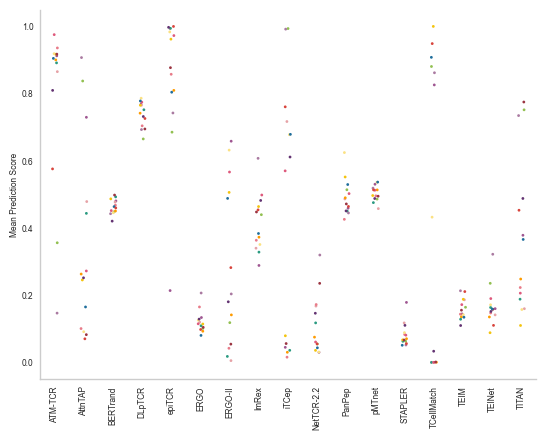

In [43]:
def plot_stats_prediction(stat, exclude=None, ax=None):
    df_tmp = prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-18:]]
    df_tmp = pd.melt(df_tmp, id_vars=['Epitope'], var_name='Method', value_name='Value')
    
    if stat.lower() == 'std':
        df_tmp = df_tmp.groupby(['Method', 'Epitope']).std()
    else:
        df_tmp = df_tmp.groupby(['Method', 'Epitope']).mean()
    df_tmp = df_tmp.reset_index()
    df_tmp['Dataset'] = df_tmp['Epitope'].apply(lambda x: 'Tumor' if x.startswith('R') else 'CMV')
    
    if exclude is not None:
        df_tmp = df_tmp[~df_tmp['Method'].isin(exclude)]
    df_tmp['Method'] = df_tmp['Method'].str.split('_').str[0]
    df_tmp['Method'] = df_tmp['Method'].map(utils_config.mapper_methods)
    
    plot = sb.stripplot(data=df_tmp, x='Method', y='Value',
                          hue='Epitope', palette=palette_epitopes,
                         size=2, ax=ax)
    
    sb.despine(ax=plot)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.grid(False)
    plot.set_ylabel(f'{stat} Prediction Score', labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=0)
    plot.legend().remove()

plot_stats_prediction('Mean', ['tulip-tcr'])

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1717456897.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


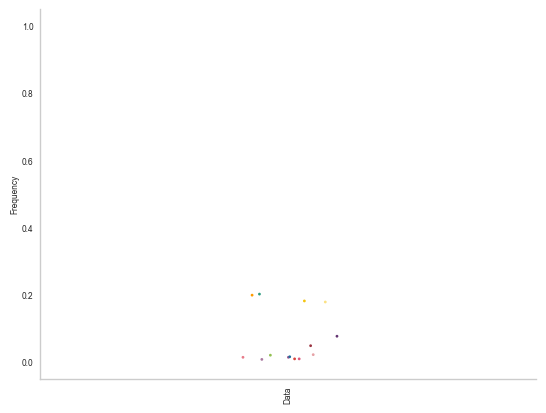

In [44]:
def plot_stats_data(stat, ax=None):
    df_tmp = prediction_scores[['Epitope', 'Label']]
    df_tmp = df_tmp.groupby('Epitope')['Label']
    if stat.lower() == 'std':
        df_tmp = df_tmp.std()
    else:
        df_tmp = df_tmp.mean()
    df_tmp = df_tmp.reset_index()
    df_tmp['Method'] = 'Data'

    plot = sb.stripplot(data=df_tmp, x='Method', y='Label',
                          hue='Epitope', palette=palette_epitopes,
                         size=2, ax=ax)
    
    sb.despine(ax=plot)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.grid(False)
    if stat.lower() == 'mean':
        plot.set_ylabel(f'Frequency', labelpad=2)
    else:
        plot.set_ylabel(f'Std', labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=0)
    plot.legend().remove()
    plot.set_ylim(-0.05, 1.05)

plot_stats_data('Mean')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1717456897.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1426713169.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1426713169.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1717456897.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1426713169.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xtic

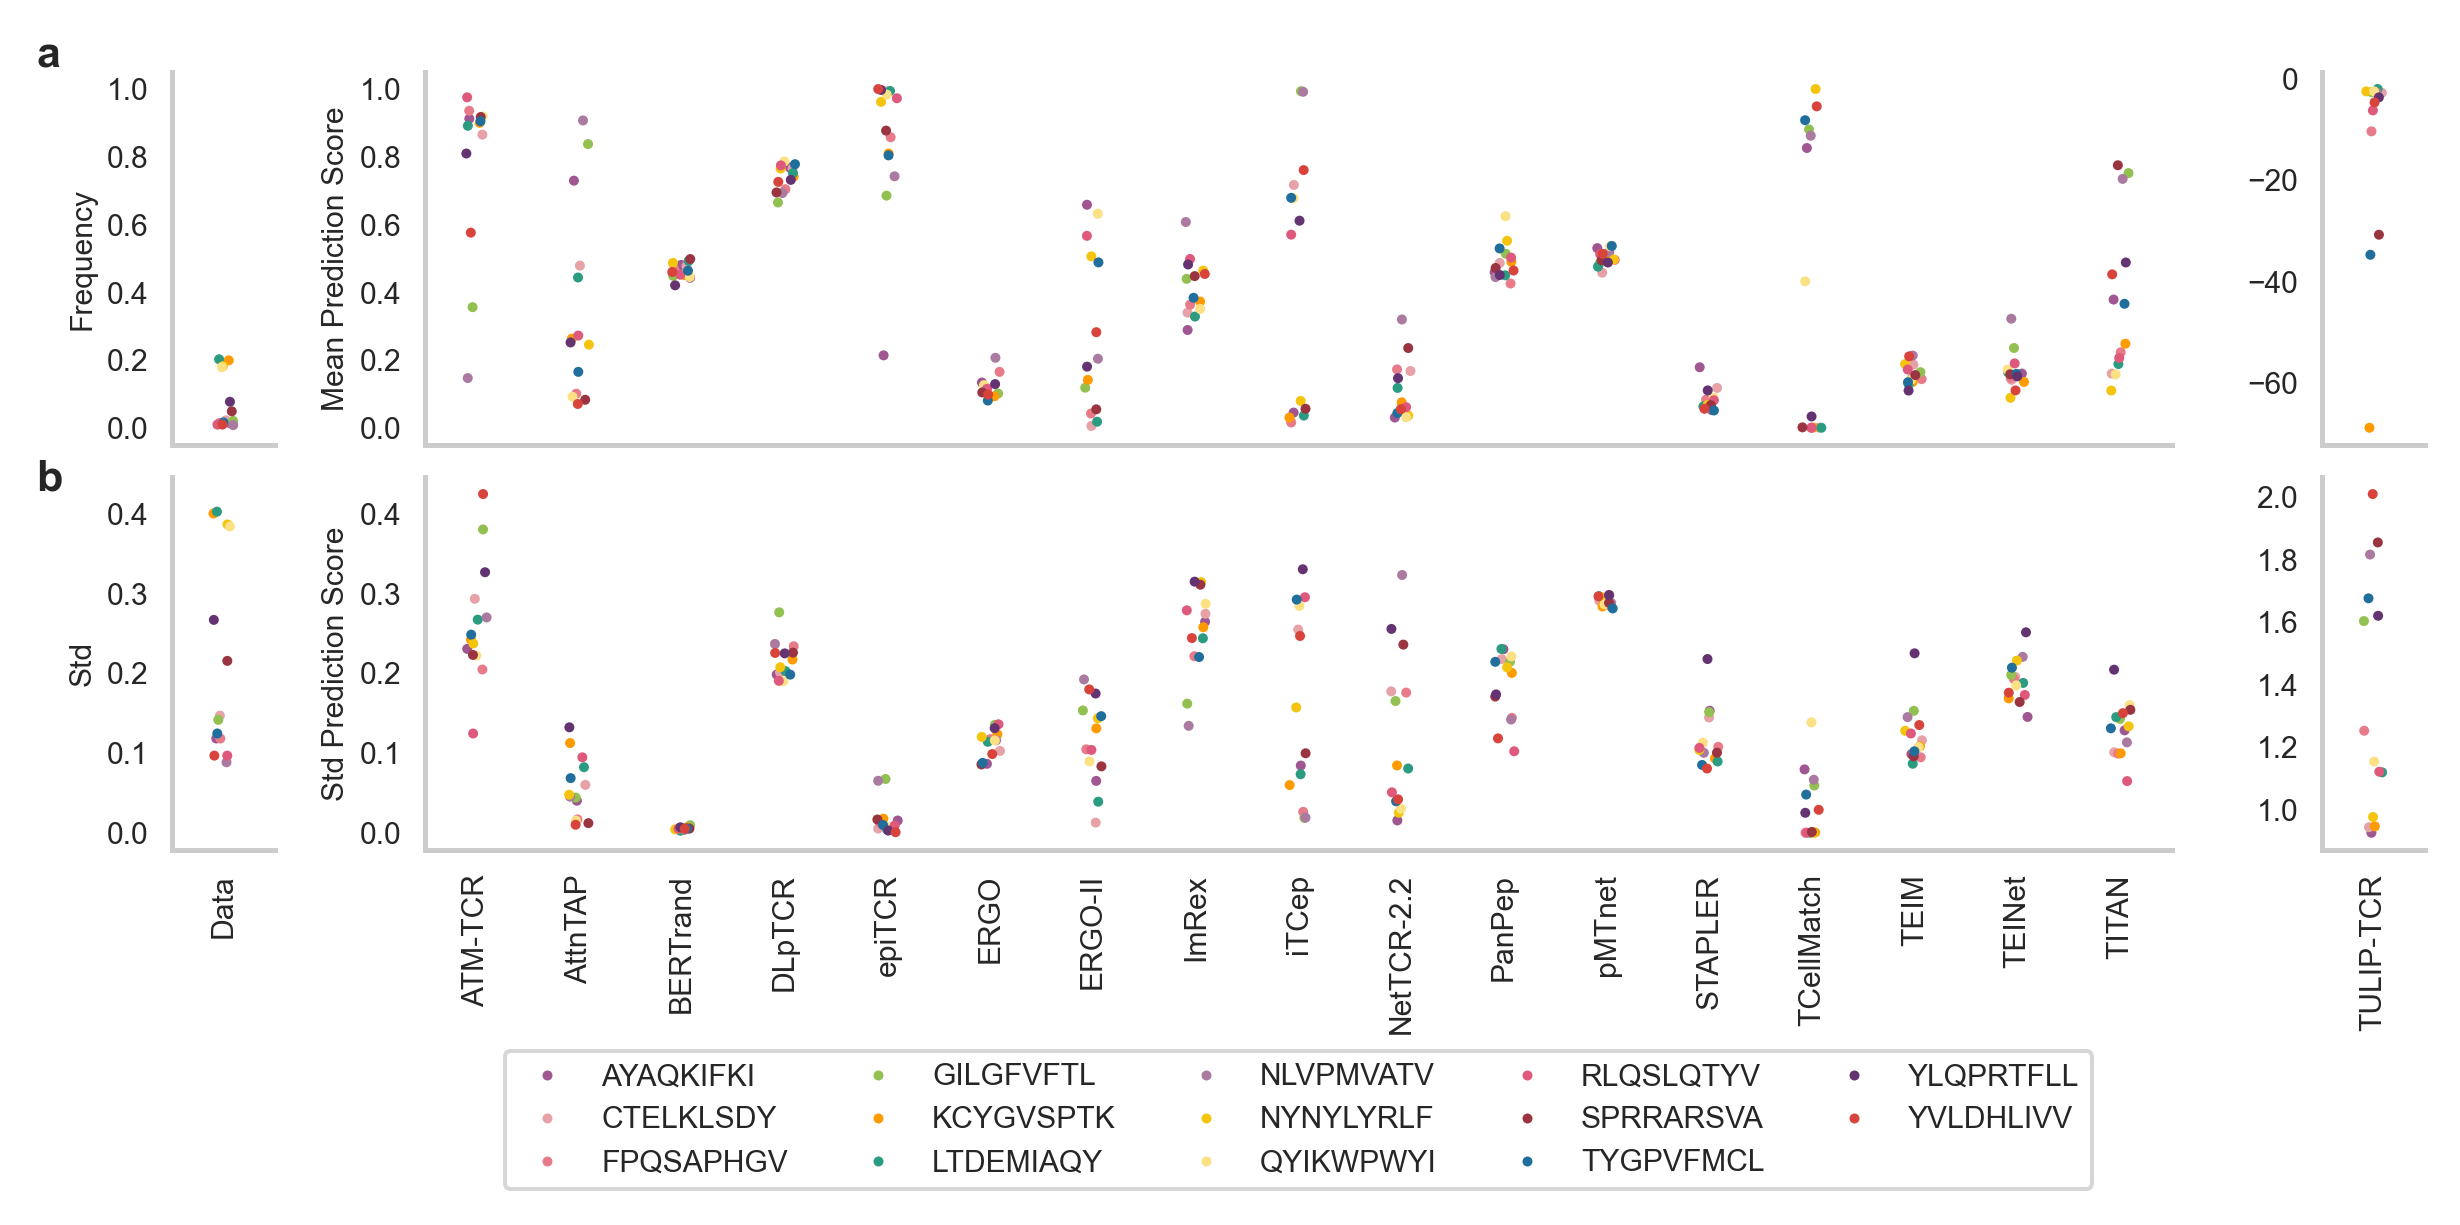

In [45]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.5),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=3,
    height_ratios=[1, 1,],
    width_ratios=[1, 17, 1],
)

ax_a1 = fig.add_subplot(gridspecs["full"][0])
ax_a2 = fig.add_subplot(gridspecs["full"][1])
ax_a3 = fig.add_subplot(gridspecs["full"][2])
ax_b1 = fig.add_subplot(gridspecs["full"][3])
ax_b2 = fig.add_subplot(gridspecs["full"][4])
ax_b3 = fig.add_subplot(gridspecs["full"][5])
    
plot_stats_data('Mean', ax_a1)
plot_stats_prediction('Mean', ['tulip-tcr'], ax_a2)
plot_stats_prediction('Mean', [el for el in best_models if el != 'tulip-tcr'], ax_a3)
plot_stats_data('Std', ax_b1)
plot_stats_prediction('Std', ['tulip-tcr'], ax_b2)
plot_stats_prediction('Std', [el for el in best_models if el != 'tulip-tcr'], ax_b3)

ax_a1.set_xticklabels([])
ax_a2.set_xticklabels([])
ax_a3.set_xticklabels([])

ax_a3.set_ylabel(None)
ax_b3.set_ylabel(None)

ax_b2.legend(ncols=5, loc='upper center', bbox_to_anchor=(0.5, -0.5), frameon=True)

ax_a1.set_ylim(ax_a2.get_ylim())
ax_b1.set_ylim(ax_b2.get_ylim())
    
fig.text(0.0, 0.975, 'a', size='x-large', weight='bold')
fig.text(0.0, 0.625, 'b', size='x-large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/sfig_viral_predictionScores.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_predictionScores.png',
           dpi=DPI, bbox_inches='tight')

## Mean Performance vs on full data

In [ ]:
colors_models = met_brewer.met_brew(name="Redon", n=18, brew_type="continuous")

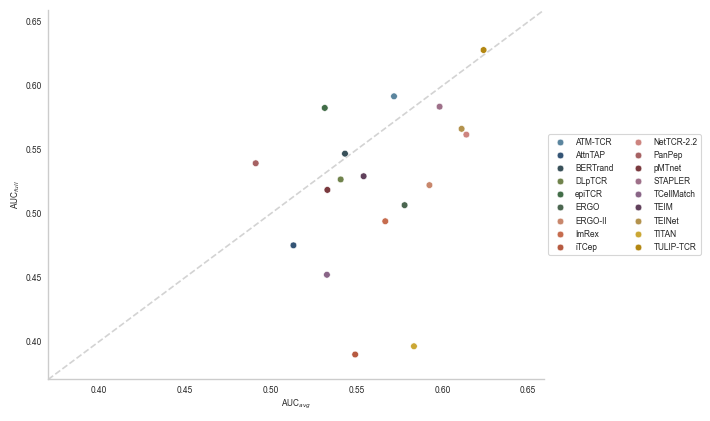

In [171]:
def plot_mean_vs_full(metric, ax=None, weighted=False):
    df_tmp = df_performance_best[(df_performance_best['Metric']==metric)
                                & (~df_performance_best['Group'].isin(['Average', 'WeightedAverage']))].copy()
    df_full = df_tmp[df_tmp['Group']=='full_data'][['BaseModel', 'Value']].set_index('BaseModel').copy()
    df_avg = df_tmp[df_tmp['Group']!='full_data'].copy()
    if weighted:
        df_avg['support'] = df_avg['Group'].map(amount_epis) / sum(amount_epis.values)
        df_avg['Value'] = df_avg['Value'] * df_avg['support'] 
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].sum())
    else:
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].mean())
    
    df_tmp = pd.concat([df_full, df_avg], axis=1)
    df_tmp.columns = ['full_data', 'averaged']
    df_tmp = df_tmp.reset_index()
    df_tmp = df_tmp.sort_values('BaseModel')
    df_tmp['BaseModel'] = df_tmp['BaseModel'].map(utils_config.mapper_methods)
    
    plot = sb.scatterplot(data=df_tmp, x='averaged', y='full_data', 
                          hue='BaseModel', palette=colors_models, ax=ax)
    
    max_ = df_tmp[['full_data', 'averaged']].max().max() * 1.05
    min_ = df_tmp[['full_data', 'averaged']].min().min() * 0.95
    plot.set_xlim((min_, max_))
    plot.set_ylim((min_, max_))
    
    plot.plot([min_, max_], [min_, max_], color='lightgrey', ls='--', zorder=-1)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_xlabel('AUC$_{avg}$', labelpad=2)
    plot.set_ylabel('AUC$_{full}$', labelpad=2)
    plot.tick_params(axis='both', pad=0)
    plot.legend(ncols=2, loc='center left', bbox_to_anchor=(1, 0.5), )
    
plot_mean_vs_full('AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1632911310.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


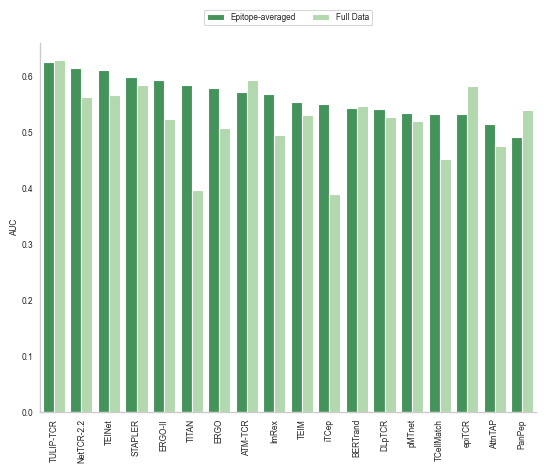

In [188]:
def plot_mean_vs_full_bar(metric, ax=None, weighted=False):
    df_tmp = df_performance_best[(df_performance_best['Metric']==metric)
                                & (~df_performance_best['Group'].isin(['Average', 'WeightedAverage']))].copy()
    df_full = df_tmp[df_tmp['Group']=='full_data'][['BaseModel', 'Value']].set_index('BaseModel').copy()
    df_avg = df_tmp[df_tmp['Group']!='full_data'].copy()
    if weighted:
        df_avg['support'] = df_avg['Group'].map(amount_epis) / sum(amount_epis.values)
        df_avg['Value'] = df_avg['Value'] * df_avg['support'] 
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].sum())
    else:
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].mean())
    
    df_avg['Type'] = 'Epitope-averaged'
    df_full['Type'] = 'Full Data'
    df_tmp = pd.concat([df_full, df_avg], axis=0)
    df_tmp = df_tmp.reset_index()
    df_tmp['BaseModel'] = df_tmp['BaseModel'].map(utils_config.mapper_methods)
    order = df_tmp[df_tmp['Type']=='Epitope-averaged'].sort_values('Value', ascending=False)['BaseModel'].values
    df_tmp['BaseModel'] = pd.Categorical(df_tmp['BaseModel'], categories=order, ordered=True)
    df_tmp = df_tmp.sort_values('BaseModel')
    
    plot = sb.barplot(data=df_tmp, x='BaseModel', y='Value', hue='Type',
                      palette='Greens_r', hue_order=['Epitope-averaged', 'Full Data'], ax=ax)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_xlabel(None)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.set_ylabel('AUC', labelpad=2)
    plot.tick_params(axis='both', pad=0)
    plot.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    
plot_mean_vs_full_bar('AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_23052\1632911310.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


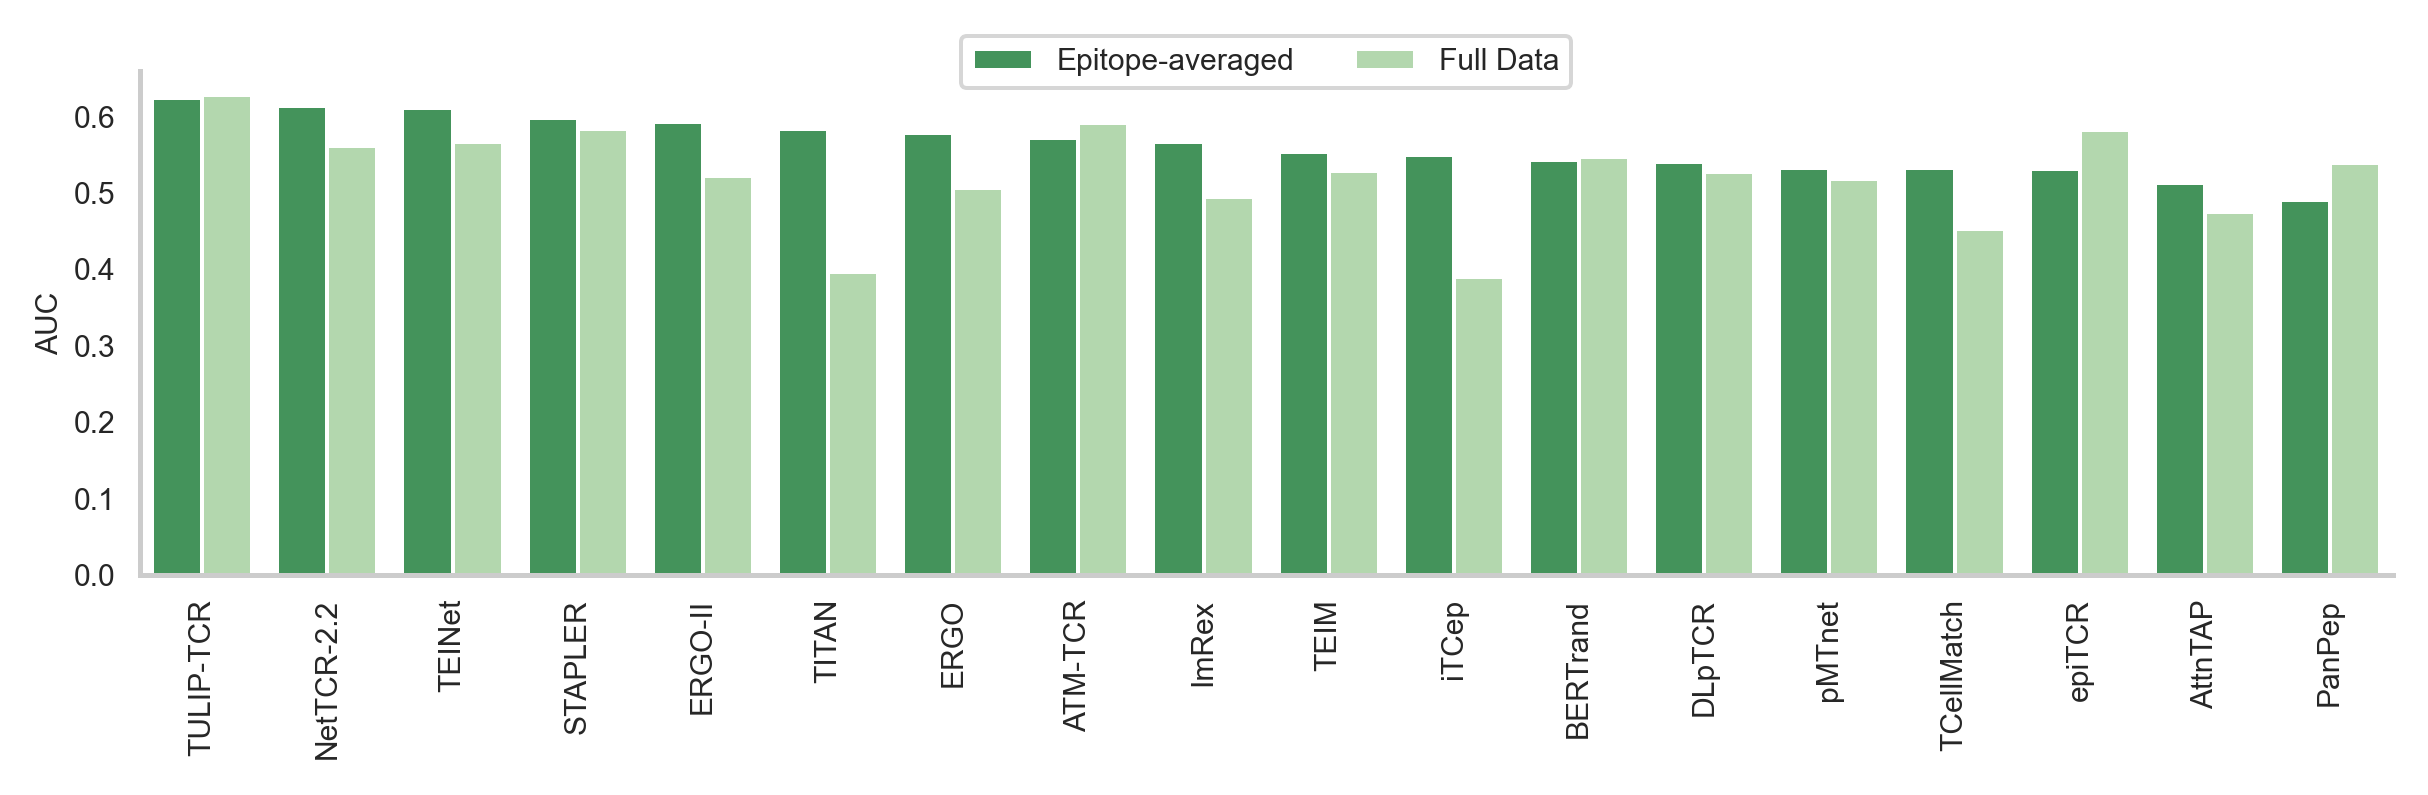

In [189]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.33),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=1,
    height_ratios=[1],
    width_ratios=[1],
)

ax_a = fig.add_subplot(gridspecs["full"][0])

plot_mean_vs_full_bar('AUC', ax_a)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_avg_vs_full.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_avg_vs_full.png',
           dpi=DPI, bbox_inches='tight')

## To Latex Table

In [46]:
from utils_latex import to_print_df, to_latex_string

In [47]:
metrics = ['AUC', 'APS', 'F1-Score', 'Rank', 'R@1', 'R@3']
df_print = to_print_df(df_performance_best, metrics, n_top=3)
df_print

Full Data                                               \
                      AUC            APS       F1-Score           Rank   
ATM-TCR     \textbf{0.59}           0.09           0.16  \textbf{6.28}   
AttnTAP              0.48           0.07           0.14           7.80   
BERTrand             0.55           0.09  \textbf{0.21}           6.92   
DLpTCR               0.53           0.08           0.14  \textbf{6.20}   
epiTCR               0.58           0.08           0.17           6.46   
ERGO                 0.51           0.09           0.13           7.45   
ERGO-II              0.52           0.09           0.14           7.35   
ImRex                0.49           0.08           0.13           7.68   
iTCep                0.39           0.05           0.13           8.93   
NetTCR-2.2           0.56           0.11           0.15           7.02   
PanPep               0.54           0.09           0.16           6.59   
pMTnet               0.52           0.08           0.14           7.27   
STAPLER     \textbf{0.58}  \textbf{0.15}           0.16           6.42   
TCellMatch           0.45           0.08           0.18           8.11   
TEIM                 0.53           0.14           0.15           7.03   
TEINet               0.57  \textbf{0.19}  \textbf{0.19}           6.81   
TITAN                0.40           0.07           0.13           8.88   
TULIP-TCR   \textbf{0.63}  \textbf{0.25}  \textbf{0.26}  \textbf{6.00}   

                                                 Per Epitope  \
                      R@1            R@3                 AUC   
ATM-TCR              0.08           0.28           0.57±0.16   
AttnTAP              0.02           0.04           0.51±0.16   
BERTrand             0.07  \textbf{0.43}           0.54±0.12   
DLpTCR               0.13           0.30           0.54±0.11   
epiTCR               0.01           0.18           0.53±0.07   
ERGO                 0.09           0.25           0.58±0.09   
ERGO-II              0.03           0.28           0.59±0.11   
ImRex                0.09           0.24           0.57±0.15   
iTCep                0.02           0.10           0.55±0.12   
NetTCR-2.2           0.13           0.23  \textbf{0.61±0.17}   
PanPep               0.13  \textbf{0.32}           0.49±0.10   
pMTnet               0.08           0.24           0.53±0.06   
STAPLER              0.13           0.31           0.60±0.17   
TCellMatch  \textbf{0.18}           0.21           0.53±0.09   
TEIM                 0.12           0.26           0.55±0.18   
TEINet      \textbf{0.16}           0.32  \textbf{0.61±0.16}   
TITAN                0.09           0.16           0.58±0.15   
TULIP-TCR   \textbf{0.26}  \textbf{0.44}  \textbf{0.62±0.17}   

                                                                        \
                           APS            F1-Score                Rank   
ATM-TCR              0.13±0.13  \textbf{0.15±0.14}           6.86±2.01   
AttnTAP              0.12±0.16           0.10±0.13           7.29±4.20   
BERTrand             0.12±0.13           0.06±0.13           7.35±4.05   
DLpTCR               0.08±0.08           0.13±0.13           6.85±2.40   
epiTCR               0.07±0.08           0.08±0.13           7.46±4.13   
ERGO                 0.13±0.14           0.13±0.12           6.36±1.71   
ERGO-II              0.13±0.12           0.13±0.14           6.78±4.00   
ImRex                0.12±0.12           0.12±0.13           7.12±2.09   
iTCep                0.11±0.14           0.12±0.13           7.23±3.93   
NetTCR-2.2           0.17±0.22           0.14±0.13  \textbf{5.97±3.05}   
PanPep               0.09±0.12           0.09±0.12           7.60±2.60   
pMTnet               0.10±0.10           0.12±0.12           6.93±1.06   
STAPLER     \textbf{0.19±0.25}           0.15±0.14  \textbf{5.90±2.19}   
TCellMatch           0.08±0.08           0.02±0.08           7.50±4.18   
TEIM                 0.17±0.24           0.12±0.22           6.25±3.00

In [48]:
to_latex_string(df_print)

\begin{table}[ht]
\resizebox{\textwidth}{!}{%}
\centering
\begin{tabular}{l l l l l l l | l l l l l l}
\toprule
 & Full Data &   &   &   &   &   & Per Epitope &   &   &   &   &   \\
  & AUC & APS & F1-Score & Rank & R@1 & R@3 & AUC & APS & F1-Score & Rank & R@1 & R@3 \\
\midrule
ATM-TCR & \textbf{0.59} & 0.09 & 0.16 & \textbf{6.28} & 0.08 & 0.28 & 0.57±0.16 & 0.13±0.13 & \textbf{0.15±0.14} & 6.86±2.01 & 0.09±0.11 & 0.26±0.18 \\
AttnTAP & 0.48 & 0.07 & 0.14 & 7.80 & 0.02 & 0.04 & 0.51±0.16 & 0.12±0.16 & 0.10±0.13 & 7.29±4.20 & 0.10±0.29 & 0.21±0.43 \\
BERTrand & 0.55 & 0.09 & \textbf{0.21} & 6.92 & 0.07 & \textbf{0.43} & 0.54±0.12 & 0.12±0.13 & 0.06±0.13 & 7.35±4.05 & 0.08±0.26 & 0.21±0.42 \\
DLpTCR & 0.53 & 0.08 & 0.14 & \textbf{6.20} & 0.13 & 0.30 & 0.54±0.11 & 0.08±0.08 & 0.13±0.13 & 6.85±2.40 & 0.12±0.15 & 0.25±0.21 \\
epiTCR & 0.58 & 0.08 & 0.17 & 6.46 & 0.01 & 0.18 & 0.53±0.07 & 0.07±0.08 & 0.08±0.13 & 7.46±4.13 & 0.05±0.18 & 0.20±0.35 \\
ERGO & 0.51 & 0.09 & 0.13 & 7.45 & 0.09 & 

In [49]:
(df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('BaseModel')['Value'].mean()<0.55).sum()

8

In [50]:
df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('Group')['Value'].max().sort_values(ascending=False)

Group
YLQPRTFLL    0.976751
YVLDHLIVV    0.948312
NLVPMVATV    0.883254
GILGFVFTL    0.835692
AYAQKIFKI    0.782901
RLQSLQTYV    0.743012
CTELKLSDY    0.717147
NYNYLYRLF    0.701843
SPRRARSVA    0.675666
TYGPVFMCL    0.671338
FPQSAPHGV    0.633104
LTDEMIAQY    0.618754
QYIKWPWYI    0.596960
KCYGVSPTK    0.583263
Name: Value, dtype: float64

In [51]:
df_data[['Epitope', 'MHC']].value_counts()

Epitope    MHC        
LTDEMIAQY  HLA-A*01:01    129
KCYGVSPTK  HLA-A*03:01    127
NYNYLYRLF  HLA-A*24:02    116
QYIKWPWYI  HLA-A*24:02    114
YLQPRTFLL  HLA-A*02:01     49
SPRRARSVA  HLA-B*07:02     31
CTELKLSDY  HLA-A*01:01     14
GILGFVFTL  HLA-A*02:01     13
TYGPVFMCL  HLA-A*24:02     10
AYAQKIFKI  HLA-A*24:02      9
FPQSAPHGV  HLA-B*07:02      9
RLQSLQTYV  HLA-A*02:01      6
YVLDHLIVV  HLA-A*02:01      6
NLVPMVATV  HLA-A*02:01      5
Name: count, dtype: int64

In [52]:
df_performance_best[
    (df_performance_best['Group']=='YLQPRTFLL')
    & (df_performance_best['Metric']=='AUC')
].sort_values('Value', ascending=False).head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
81,teim,Viral,YLQPRTFLL,638,TTP,AUC,0.976751,teim,
81,teinet_SMALL_DS,Viral,YLQPRTFLL,638,TTP,AUC,0.959149,teinet,SMALL_DS
81,tulip-tcr,Viral,YLQPRTFLL,638,TTP,AUC,0.953293,tulip-tcr,
81,nettcr_t.1.v.0,Viral,YLQPRTFLL,638,TTP,AUC,0.930460,nettcr,t.1.v.0
81,stapler,Viral,YLQPRTFLL,638,TTP,AUC,0.927619,stapler,


In [53]:
(prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-18:]
                 ].groupby('Epitope').mean()>0.5).sum()

atm-tcr                  12
attntap_VDJDB             3
bertrand                  0
dlptcr_BETA              14
epitcr_WITH_MHC          13
ergo-i_AE_VDJDB           0
ergo-ii_VDJDB             4
imrex_FULL                1
itcep                     8
nettcr_t.1.v.0            0
panpep                    5
pmtnet                    7
stapler                   0
tcellmatch_LINEAR_CV1     6
teim                      0
teinet_SMALL_DS           0
titan                     3
tulip-tcr                 0
dtype: int64

In [54]:
df_data['Epitope'].value_counts(normalize=True)

Epitope
LTDEMIAQY    0.202194
KCYGVSPTK    0.199060
NYNYLYRLF    0.181818
QYIKWPWYI    0.178683
YLQPRTFLL    0.076803
SPRRARSVA    0.048589
CTELKLSDY    0.021944
GILGFVFTL    0.020376
TYGPVFMCL    0.015674
AYAQKIFKI    0.014107
FPQSAPHGV    0.014107
YVLDHLIVV    0.009404
RLQSLQTYV    0.009404
NLVPMVATV    0.007837
Name: proportion, dtype: float64

In [55]:
prediction_scores[['Epitope', 'Label']].groupby('Epitope')['Label'].std().sort_values()

Epitope
NLVPMVATV    0.088248
RLQSLQTYV    0.096595
YVLDHLIVV    0.096595
FPQSAPHGV    0.118023
AYAQKIFKI    0.118023
TYGPVFMCL    0.124308
GILGFVFTL    0.141394
CTELKLSDY    0.146614
SPRRARSVA    0.215177
YLQPRTFLL    0.266487
QYIKWPWYI    0.383388
NYNYLYRLF    0.385997
KCYGVSPTK    0.399606
LTDEMIAQY    0.401952
Name: Label, dtype: float64

In [56]:
prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-18:]
                 ].groupby('Epitope').std().mean()<0.1

atm-tcr                  False
attntap_VDJDB             True
bertrand                  True
dlptcr_BETA              False
epitcr_WITH_MHC           True
ergo-i_AE_VDJDB          False
ergo-ii_VDJDB            False
imrex_FULL               False
itcep                    False
nettcr_t.1.v.0           False
panpep                   False
pmtnet                   False
stapler                  False
tcellmatch_LINEAR_CV1     True
teim                     False
teinet_SMALL_DS          False
titan                    False
tulip-tcr                False
dtype: bool

In [57]:
prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-18:]
                 ].groupby('Epitope').mean().mean()<0.2

atm-tcr                  False
attntap_VDJDB            False
bertrand                 False
dlptcr_BETA              False
epitcr_WITH_MHC          False
ergo-i_AE_VDJDB           True
ergo-ii_VDJDB            False
imrex_FULL               False
itcep                    False
nettcr_t.1.v.0            True
panpep                   False
pmtnet                   False
stapler                   True
tcellmatch_LINEAR_CV1    False
teim                      True
teinet_SMALL_DS           True
titan                    False
tulip-tcr                 True
dtype: bool